In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load libraries
## For survival analysis - using scikit-survival
## To make figures - using matplotlib

## Clear workspace
# (Not needed in Python - variables are local to script)

## Fix seed - maintain direction of PCs
np.random.seed(111222333)

######################################   FUNCTION DEFINITIONS   ############################################
## FUNCTIONS START >>> 

###############################   < READ, WRITE AND CLEAN DATA >  ##########################################

def markIncsFromCodeBook(codeBook):
    """Selects all columns marked as data ("1" in Data column) in codebook for inclusion in master dataset"""
    incFlags = codeBook["Data"].values  ## This column is "1" for include in dataset, 0 for not (comments or demo data)
    incNames = codeBook.iloc[:, 0].astype(str).values
    incList = np.column_stack((incNames, incFlags))
    return incList


def dropCols(dataSet, incList):
    """Simply drops everything not flagged with 1 in incList (Data)"""
    incInds = np.where(incList[:, 1].astype(int) == 1)[0]
    incTerms = incList[:, 0][incInds]
    nTerms = len(incTerms)
    
    ## The first column is always the subject number (SEQN) - add that back
    outData = dataSet.iloc[:, 0:1].copy()
    
    for i in range(1, nTerms):
        ## loop over terms that have a "1" in column 2 of the incList, find those in
        ## dataSet and include in output dataSet
        nextTerm = incTerms[i]
        if nextTerm in dataSet.columns:
            nextCol = dataSet[nextTerm]
            outData = pd.concat([outData, nextCol], axis=1)
    
    ## Name first column appropriately and return resulting dataset
    outData.columns = ['SEQN'] + list(outData.columns[1:])
    return outData


def dropNAcolumns(dataSet, pNAcut, incSwitch, verbose):
    """This takes a single cutoff fraction and drops all columns (features)
    that contain more NAs than allowed by the cutoff.
    However, if force include flag is set (==1) for a column, we will force the inclusion of feature"""
    
    nRows = dataSet.shape[0]
    nCols = dataSet.shape[1]
    forceFlags = np.zeros(nCols)
    
    ## If incSwitch IS set, we read them from the codebook
    if incSwitch == 1:
        ## Read include flags from codebook
        codeBookFlags = codeBook['ForceInc'].values
        ## Identify column terms that we cannot drop
        nForced = np.sum(codeBookFlags)
        forceIncTerms = codeBook['Var'][codeBookFlags == 1].values
        ## Now identify columns in dataset that need to be retained
        for i in range(nForced):
            nextTerm = forceIncTerms[i]
            if nextTerm in dataSet.columns:
                forceThis = dataSet.columns.get_loc(nextTerm)
                ## Flip the respective forceFlag to 1 - this column cannot be dropped
                nrOfNAs = dataSet.iloc[:, forceThis].isna().sum()
                if verbose:
                    print(f"Applying force flag to: {nextTerm}")
                    print(f"\t - this will include:\t {nrOfNAs}\t NAs in:\t {nRows}  {round(nrOfNAs/nRows*100, 2)}%")
                forceFlags[forceThis] = 1
    
    ## Now drop all columns with too many NAs
    naColSum = dataSet.isna().sum()
    naColP = naColSum / nRows
    
    ## Keep only those columns (features) for which naColP (number of NAs) is smaller than pNAcut
    keepCols = naColP < pNAcut
    
    ## Finally, recover all columns that we decided to force (retain)
    ## Merge keepCols (columns that will be kept due to cutoff) and forceFlags
    keepCols = keepCols | (forceFlags == 1)
    dataSet = dataSet.loc[:, keepCols]
    
    ## Print dimension of surviving matrix and list of surviving variables
    nrows = dataSet.shape[0]
    ncols = dataSet.shape[1]
    varNames = dataSet.columns
    humNames = varNames
    
    for i in range(1, len(varNames)):
        varName = varNames[i]
    
    return dataSet


def qDataMatGen(masterData, incList):
    """Loop over masterData and keep any column that has a zero in the "data" column"""
    allTerms = masterData.columns
    nTerms = masterData.shape[1]  ## number of total terms (columns) in masterData
    nIncFlags = incList.shape[0]  ## number of terms in codebook - for which we know include flags
    
    ## The first column of the qDataMatrix has to be SEQN number - add these first
    qDataNames = ["SEQN"]
    qDataMatrix = masterData.iloc[:, 0:1].copy()
    
    ## Loop over all terms (columns) in masterData - extract one term (column) at a time
    for i in range(1, nTerms):
        ## look at the next term in the data and get the respective flag from the incList
        nextTerm = allTerms[i]
        
        ## Now loop over all terms in the incList and get the flag for the current term
        flag = 0  ## Graceful default is 0 - not include
        for j in range(nIncFlags):
            if incList[j, 0] == nextTerm:
                ## Read the inc flag (second entry of that column) and return it
                flag = int(incList[j, 1])
        
        if flag == 0:
            ## If include == 0, we will include that parameter in the qDataMatrix
            qDataColumn = masterData.iloc[:, i]  ## Keep the current column for inclusion to qDataMatrix
            qDataMatrix = pd.concat([qDataMatrix, qDataColumn], axis=1)  ## Add current column to qDataMatrix
            qDataNames.append(nextTerm)  ## Also keep the current column name (nextTerm) as column name
    
    qDataMatrix.columns = qDataNames  ## Update all column names
    return qDataMatrix  ## Return the matrix


def getNonNARows(dataSet):
    """Identify rows that contain NAs and drop them by only retaining those that do not
    sums over NAs are NA so only rows with no (zero) NAs return !is.na"""
    keepRows = (dataSet.isna().sum(axis=1) == 0)
    return keepRows


#########################  < CALCULATING DERIVED FEATURES FROM DATA >  #####################################

def popPCFIfs1(qDataMat):
    """This will calculate our frailty index / disease and comorbidity index for each subject
    and populate the matrix
    
    NOTE: we will allow NAs here - so check that the variables are all there"""
    
    BPQ020 = qDataMat["BPQ020"].copy()
    DIQ010 = qDataMat["DIQ010"].copy()
    HUQ010 = qDataMat["HUQ010"].copy()
    HUQ020 = qDataMat["HUQ020"].copy()
    HUQ050 = qDataMat["HUQ050"].copy()
    HUQ070 = qDataMat["HUQ070"].copy()
    KIQ020 = qDataMat["KIQ020"].copy()
    MCQ010 = qDataMat["MCQ010"].copy()
    MCQ053 = qDataMat["MCQ053"].copy()
    MCQ160A = qDataMat["MCQ160A"].copy()
    MCQ160B = qDataMat["MCQ160B"].copy()
    MCQ160C = qDataMat["MCQ160C"].copy()
    MCQ160D = qDataMat["MCQ160D"].copy()
    MCQ160E = qDataMat["MCQ160E"].copy()
    MCQ160F = qDataMat["MCQ160F"].copy()
    MCQ160G = qDataMat["MCQ160G"].copy()
    MCQ160I = qDataMat["MCQ160I"].copy()
    MCQ160J = qDataMat["MCQ160J"].copy()
    MCQ160K = qDataMat["MCQ160K"].copy()
    MCQ160L = qDataMat["MCQ160L"].copy()
    MCQ220 = qDataMat["MCQ220"].copy()
    OSQ010A = qDataMat["OSQ010A"].copy()
    OSQ010B = qDataMat["OSQ010B"].copy()
    OSQ010C = qDataMat["OSQ010C"].copy()
    OSQ060 = qDataMat["OSQ060"].copy()
    PFQ056 = qDataMat["PFQ056"].copy()
    
    ## Give "safe" value to all NAs ...
    BPQ020.fillna(2, inplace=True)
    DIQ010.fillna(2, inplace=True)
    HUQ010.fillna(3, inplace=True)
    HUQ020.fillna(3, inplace=True)
    HUQ050.fillna(0, inplace=True)
    HUQ070.fillna(2, inplace=True)
    KIQ020.fillna(2, inplace=True)
    MCQ010.fillna(2, inplace=True)
    MCQ053.fillna(2, inplace=True)
    MCQ160A.fillna(2, inplace=True)
    MCQ160B.fillna(2, inplace=True)
    MCQ160C.fillna(2, inplace=True)
    MCQ160D.fillna(2, inplace=True)
    MCQ160E.fillna(2, inplace=True)
    MCQ160F.fillna(2, inplace=True)
    MCQ160G.fillna(2, inplace=True)
    MCQ160I.fillna(2, inplace=True)
    MCQ160J.fillna(2, inplace=True)
    MCQ160K.fillna(2, inplace=True)
    MCQ160L.fillna(2, inplace=True)
    MCQ220.fillna(2, inplace=True)
    OSQ010A.fillna(2, inplace=True)
    OSQ010B.fillna(2, inplace=True)
    OSQ010C.fillna(2, inplace=True)
    OSQ060.fillna(2, inplace=True)
    PFQ056.fillna(2, inplace=True)
    
    ## Binary yes/no decision vector
    binVec = np.column_stack([
        (BPQ020 == 1), ((DIQ010 == 1) | (DIQ010 == 3)), (KIQ020 == 1), (MCQ010 == 1), (MCQ053 == 1),
        (MCQ160A == 1), (MCQ160C == 1), (MCQ160D == 1), (MCQ160E == 1), (MCQ160F == 1),
        (MCQ160G == 1), (MCQ160I == 1), (MCQ160J == 1), (MCQ160K == 1), (MCQ160L == 1),
        (MCQ220 == 1), (OSQ010A == 1), (OSQ010B == 1), (OSQ010C == 1), (OSQ060 == 1),
        (PFQ056 == 1), (HUQ070 == 1)
    ])
    
    sumOverBinVec = binVec.sum(axis=1) / 22
    return sumOverBinVec


def popPCFIfs2(qDataMat):
    
    HUQ010 = qDataMat["HUQ010"].copy()
    HUQ020 = qDataMat["HUQ020"].copy()
    HUQ010.fillna(3, inplace=True)
    HUQ020.fillna(3, inplace=True)
    
    ## If sick/feeling bad, get score of 2 to 4 - if getting worse -> get 2x modifier
    ## if getting better -> 1/2 modifier
    aVec = ((HUQ010 == 4) * 2 + (HUQ010 == 5) * 4)
    dVec = (1 - (HUQ020 == 1) * 0.5 + (HUQ020 == 2))
    fScore = aVec * dVec
    
    return fScore


def popPCFIfs3(qDataMat):
    """This basically codes NHANES HUQ050: "Number times received healthcare over past year" """
    HUQ050 = qDataMat["HUQ050"].copy()
    HUQ050.fillna(0, inplace=True)
    HUQ050[HUQ050 == 77] = 0  ## Comment codes ("Refused")
    HUQ050[HUQ050 == 99] = 0  ## Comment codes ("Do not know")
    return HUQ050


def populateLDL(dataMat, qDataMat):
    """This function will calculate LDL and adds it to the dataMatrix
    LDL - calculated from:
       Variable: LBDTCSI	        Total Cholesterol (mmol/L)
       Variable: LBDHDLSI	HDL (mmol/L)
       Variable: LBDSTRSI	Triglycerides (mmol/L)
    Formula:  LDL-C=(TC)–(triglycerides/5)– (HDL-C).
    NOTES: Can be inaccurate if triglycerides are very high (above 150 mg/dL)"""
    
    nSubs = dataMat.shape[0]
    
    ## Extract all relevant variables from data matrix
    totCv = dataMat["LBDTCSI"].values
    HDLv = dataMat["LBDHDLSI"].values
    triGv = dataMat["LBDSTRSI"].values
    seqVec = dataMat["SEQN"].values
    LDLvec = np.zeros(nSubs)
    
    ## Loop over all subjects and update LDL
    for i in range(nSubs):
        totC = totCv[i]
        HDL = HDLv[i]
        TG = triGv[i]
        LDL = 0
        
        ## Check that we do not have any NAs here
        # actual condition is supposed to be  ~(np.isnan(totC) or np.isnan(HDL) or np.isnan(TG))
        # but we have buggy R prototype and have to replicate that
        condition = (not np.isnan(totC)) * (not np.isnan(HDL)) * (not np.isnan(TG))
        if condition:
            ## Calculate LDL from triglycerides and total cholesterol
            LDL = (totC - (TG / 5) - (HDL))
        
        LDLvec[i] = LDL
    
    return LDLvec


#############################  < DATA SELECTION - ROWS / SUBJECTS >  ####################################

def selectAgeBracket(qMat, ageCutLower, ageCutUpper):
    """Apply a age bracket to dataset - only retain samples between upper and lower age limit"""
    keepRows = ((qMat["RIDAGEYR"] >= ageCutLower) & (qMat["RIDAGEYR"] <= ageCutUpper))
    return keepRows


def nonAccidDeathFlags(qMat):
    """Here we will return keep flags for all subjects who die of non-accidental deaths
    The cause of death (leading) is recorded (if known) in the questionnaire data matrix
    qDatMat in the "UCOD_LEADING" column
    Possible values in "UCOD_LEADING" are:
    001 = Disease of the heart
    002 = Malignant neoplasm
    003 = Chronic lower respiratory disease
    004 = Accidents and unintentional injuries
    005 = Cerebrovascular disease
    007 = Diabetes
    008 = Influenza and pneumonia
    009 = Nephritis, kidney issues
    010 = All other causes (residuals)
    NA  = no info (the vast majority of cases)"""
    
    ## Extract cause of deaths
    causeOfDeath = qMat["UCOD_LEADING"].copy()
    ## Then drop NAs (turn into zeros)
    causeOfDeath.fillna(0, inplace=True)
    keepFlags = causeOfDeath != 4
    
    return keepFlags


def foldOutliers(dataMatNorm, zScoreMax):
    """Fold in outlier z-scores"""
    
    print(f"> Folding in outliers at maximum total zScore: {zScoreMax}", end="")
    ## Now truncate / fold outliers and show boxplots
    
    dataMatNorm_folded = dataMatNorm.copy()
    allTerms = dataMatNorm.columns[1:]
    
    for nextTerm in allTerms:
        colVals = dataMatNorm[nextTerm].values
        if np.isinf(colVals).any():
            print(f"Infinite value in: {nextTerm}")
        ## boxplot(colVals,main=paste(nextTerm,"-before"))
        foldThese = np.abs(colVals) > zScoreMax
        colVals[foldThese] = np.sign(colVals[foldThese]) * zScoreMax
        ## boxplot(colVals,main=paste(nextTerm,"-after"))
        ## readline()
        dataMatNorm_folded[nextTerm] = colVals
    
    print(" ... Done")
    return dataMatNorm_folded


def digiCot(dataMat):
    """Digitize continine to turn into smoking intensity
    Most clinics do not routinely measure cotinine - so here we will
    bin cot as follows:
    0  <= cot < 10 are non smokers (0)
    10 >= cot < 100 are light smokers (1)
    100 >= cot < 200 are moderate smokers (2)
    anything above 200 is a heavy smoker (3)"""
    
    print("> Digitizing cotinine data ... ", end="")
    cot = dataMat["LBXCOT"].copy()
    dataMat_out = dataMat.copy()
    dataMat_out.loc[cot < 10, "LBXCOT"] = 0
    dataMat_out.loc[(cot >= 10) & (cot < 100), "LBXCOT"] = 1
    dataMat_out.loc[(cot >= 100) & (cot < 200), "LBXCOT"] = 2
    dataMat_out.loc[cot >= 200, "LBXCOT"] = 3
    print("Done\n")
    return dataMat_out

In [2]:
#############################    MATH AND ANALYSIS FUNCTIONS    #######################################

# def normAsZscores_99_young_mf(dataSet, qDataMat, dataSet_ref, qDataMat_ref):
#     """Normalize by training set (00/99) only"""
    
#     seqSel = qDataMat_ref["yearsNHANES"] == 9900
    
#     ## Select age cutoff
#     ageVec = qDataMat_ref["RIDAGEYR"]
#     ageSel = ageVec <= 50
    
#     ## Combine selections - all in reference data only
#     selVec = ageSel & seqSel
    
#     ## extract data matrix
#     dataSet_temp = dataSet_ref[selVec]
#     ## Sex selection vector - true for males
#     sexSel_temp = qDataMat_ref.loc[selVec, "RIAGENDR"] == 1  ## Sex selection vector for 1999 to 2000 data only
#     sexSel = qDataMat["RIAGENDR"] == 1  ## Sex selection vector for dataset to be normalized
    
#     ## Normalize data by column average for each column independently
#     nRows = dataSet.shape[0]
#     nCols = dataSet.shape[1]
    
#     ## Make normalized matrix by turning each value into z-score
#     dataMatN = dataSet.copy()
#     ## There is certainly a more elegant way of doing this - but for hackability, lets just do a
#     ## simple loop for now - column 1 is still the subject seq number - will not be normalized
#     dataMatN.iloc[:, 0] = dataSet.iloc[:, 0]
    
#     ## We will not apply normalization to some columns - fs scores in particular
#     skipCols = ["fs1Score", "fs2Score", "fs3Score", "LBXCOT", "LBDBANO"]
    
#     ## Loop over all columns - starting from column 2 (first data col)
#     for col in range(1, nCols):
#         if dataSet.columns[col] not in skipCols:
#             ## Median and MAD - males
#             med_m = np.median(dataSet_temp[sexSel_temp].iloc[:, col])
#             mad_m = stats.median_abs_deviation(dataSet_temp[sexSel_temp].iloc[:, col], nan_policy='omit')
            
#             ## Median and MAD - females
#             med_f = np.median(dataSet_temp[~sexSel_temp].iloc[:, col])
#             mad_f = stats.median_abs_deviation(dataSet_temp[~sexSel_temp].iloc[:, col], nan_policy='omit')
            
#             ## Loop over all rows in current column and normalize each value by column mean
#             for row in range(nRows):
#                 ## Determine sex
#                 sexNow = int(sexSel.iloc[row])
#                 if sexNow == 1:  # This is a male
#                     mad = mad_m
#                     med = med_m
#                 if sexNow == 0:  # This is a female
#                     mad = mad_f
#                     med = med_f
                
#                 ## Now calculate z-score for each row of this column - use sex-specific median and MAD values
#                 zScore_nonN = (dataSet.iloc[row, col] - med) / mad
                
#                 ## Store normalized and log2 fold changes (vs. column average) in new matrices
#                 dataMatN.iloc[row, col] = zScore_nonN
    
#     return dataMatN

def normAsZscores_99_young_mf(dataSet, qDataMat, dataSet_ref, qDataMat_ref):
    """Normalize by training set (1999–2000 only), sex-specific median & MAD (R-equivalent)."""

    # --- reference subset: yearsNHANES == 9900 and RIDAGEYR <= 50 ---
    years = qDataMat_ref["yearsNHANES"]
    seqSel = (years == 9900) | (years.astype(str) == "9900")
    ageSel = qDataMat_ref["RIDAGEYR"] <= 50
    selVec = seqSel & ageSel

    dataSet_temp = dataSet_ref.loc[selVec].copy()
    sexSel_temp = (qDataMat_ref.loc[selVec, "RIAGENDR"] == 1)  # True for males in REF
    sexSel = (qDataMat["RIAGENDR"] == 1)                       # True for males in TARGET

    nRows, nCols = dataSet.shape
    dataMatN = dataSet.copy()

    # column 0 stays as-is (e.g., SEQN)
    dataMatN.iloc[:, 0] = dataSet.iloc[:, 0]

    skipCols = {"fs1Score", "fs2Score", "fs3Score", "LBXCOT", "LBDBANO"}

    def safe_z(x, med, mad_val):
        if np.isnan(med) or np.isnan(mad_val):
            return np.full_like(x, np.nan, dtype=float)
        if mad_val == 0 or np.isclose(mad_val, 0.0):
            # exact median -> 0, otherwise NaN (mirrors division-by-zero behavior without infs)
            return np.where(np.isfinite(x), np.where(x == med, 0.0, np.nan), np.nan)
        return (x - med) / mad_val

    for col in range(1, nCols):
        name = dataSet.columns[col]
        if name in skipCols:
            continue

        # reference data split by sex (coerce to numeric; NAs are handled downstream)
        ref_m = pd.to_numeric(dataSet_temp.loc[sexSel_temp, name], errors="coerce").to_numpy()
        ref_f = pd.to_numeric(dataSet_temp.loc[~sexSel_temp, name], errors="coerce").to_numpy()

        # NA-robust medians (align with MAD's nan omission)
        med_m = np.nanmedian(ref_m)
        med_f = np.nanmedian(ref_f)

        # MAD with normal-consistent scaling (matches R's mad default), omit NaNs
        mad_m = stats.median_abs_deviation(ref_m, scale="normal", nan_policy="omit")
        mad_f = stats.median_abs_deviation(ref_f, scale="normal", nan_policy="omit")

        # target column values
        x = pd.to_numeric(dataSet.iloc[:, col], errors="coerce").to_numpy()

        # compute male/female z-scores then merge by target sex
        z_m = safe_z(x, med_m, mad_m)
        z_f = safe_z(x, med_f, mad_f)
        z = np.where(sexSel.to_numpy(), z_m, z_f)

        dataMatN.iloc[:, col] = z

    return dataMatN

def boxCoxTransform(boxCox_lam, dataMat):
    """Apply box cox transforms based on lambda given"""
    dataMat_out = dataMat.copy()
    allTerms = dataMat.columns[1:]
    print("> Applying boxCox transformed  ... ", end="")
    for nextTerm in allTerms:
        ## Get column number
        dataColNr = dataMat.columns.get_loc(nextTerm)
        if nextTerm in boxCox_lam.columns:
            lamNr = boxCox_lam.columns.get_loc(nextTerm)
            ## Get next transformation
            nextLam = boxCox_lam.iloc[0, lamNr]
            ## Get next data item (column)
            colVals = dataMat[nextTerm].copy()
            ## Selection of transformation is based on lambda value
            if not pd.isna(nextLam):  ## If NA, do nothing
                if nextLam == 0:
                    colVals = np.log(colVals)  ## If the lambda value is zero, we log the data column
                else:
                    colVals = (colVals**nextLam - 1) / nextLam  ## If it is neither NA nor zero - boxCox formula for lambda
            dataMat_out[nextTerm] = colVals
    
    print("Done")
    return dataMat_out


def projectToSVD(inputMat, svdCoordMat):
    """Project inputMat data matrix into the same PC coordinates provided by svdCoordMat"""
    
    print("> Projecting data into PC coordinates  ... ", end="")
    mSamples = inputMat.shape[0]
    nSVs = svdCoordMat.shape[1]
    pcMat = np.zeros((mSamples, nSVs))  ## Empty data matrix in PC coordinates
    
    ## Doing loop to calculate coordinates for samples in terms of PCs - could do matrix mult instead
    for sample in range(mSamples):
        ## Current sample is current row of data (input) matrix
        curSample = inputMat[sample, :]
        
        ## Now loop over all nSVs and determine
        for pcNr in range(nSVs):
            ## current PC vector is the column
            curPC = svdCoordMat[:, pcNr]
            coord = curSample @ curPC
            pcMat[sample, pcNr] = coord
    
    print("Done")
    return pcMat


# def getSurvTime(qMatrix):
#     """Function to calculate survival time between enrollment and end of follow up
#     Get the age (in month) at time of initial screen
    
#     For those individuals who died before the cutoff date in 2019, we have
#     information on time between survey and death - for survivors, the entry is time
#     between the initial exam and the end of the follow up
    
#     NOTE: THIS IS REALLY NOT SURVIVAL TIME BUT TIME TO FOLLOW UP - interpret with eventFlags!"""
    
#     survTimes = qMatrix["PERMTH_EXM"].values
#     return survTimes


# def getEventVec(qMatrix, cause):
#     """Read qDataMatrix and determine if individual died during study period or was censored
#     that is, survived beyond the end of the study ..."""
    
#     if cause == 0:  ## IF cause is 0, we do not care what people died from and report all deaths
#         eventFlags = qMatrix["MORTSTAT"].values
#         return eventFlags
    
#     if cause != 0:  ## If cause is > 0, we will report only specific causes of death
#         eventFlags = qMatrix["MORTSTAT"].values
#         CODFlags = qMatrix["UCOD_LEADING"].values
        
#         if cause == 1:  ## Heart disease deaths only
#             countThese = (CODFlags == 1)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 2:  ## Cancer deaths only
#             countThese = (CODFlags == 2)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 3:  ## COPD deaths only
#             countThese = (CODFlags == 3)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 4:  ## Accident deaths only
#             countThese = (CODFlags == 4)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 5:  ## Stroke deaths only
#             countThese = (CODFlags == 5)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 6:  ## Deaths directly from AD only
#             countThese = (CODFlags == 6)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 7:  ## Deaths directly form diabetes only
#             countThese = (CODFlags == 7)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 8:  ## Deaths from influenza and pneumonia
#             countThese = (CODFlags == 8)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 9:  ## Deaths from kidney issues
#             countThese = (CODFlags == 9)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         ## We can also specify some causes that are combinations or exclusions of others
#         if cause == 10:  ## All NON CVD (not MCI, not stroke) deaths only
#             countThese = ((CODFlags != 1) & (CODFlags != 5))
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 11:  ## All non accidental deaths only
#             countThese = (CODFlags != 4)
#             eventFlags = eventFlags * countThese
#             return eventFlags
#         if cause == 12:  ## All CVD-related deaths - including stroke
#             countThese = ((CODFlags == 1) | (CODFlags == 5))
#             eventFlags = eventFlags * countThese
#             return eventFlags


# def makeSurvObject(qMatrix, causeOfDeath):
#     """Take survival times and censor vector and make a survival object"""
    
#     ## First, get event flags from qMatrix - subjects that died have 1, those that survived have 0 in here
#     eventFlags = getEventVec(qMatrix, causeOfDeath)
    
#     ## Then, get survival times (either time between exam and death (if dead) or time to end of follow up (alive)
#     times = getSurvTime(qMatrix)
    
#     ## Now make a survival object (survival library)
#     ## In Python with scikit-survival, we create structured array
#     survObj = np.array([(bool(e), t) for e, t in zip(eventFlags, times)],
#                       dtype=[('event', '?'), ('time', '<f8')])
    
#     return survObj

import numpy as np
import pandas as pd

def getSurvTime(qMatrix: pd.DataFrame):
    return qMatrix["PERMTH_EXM"].to_numpy()

def _as_float(series):
    # Ensure we carry NaNs (don’t coerce to int/bool too early)
    return pd.to_numeric(series, errors="coerce").to_numpy(dtype=float)

def getEventVec(qMatrix: pd.DataFrame, cause: int):
    """
    Return *float* array with values {0.0, 1.0, np.nan}, mirroring R behavior.
    For cause-specific deaths, NA in UCOD_LEADING propagates: 0*NA -> NA in R.
    """
    eventFlags = _as_float(qMatrix["MORTSTAT"])  # may contain NaN

    if cause == 0:
        return eventFlags

    CODFlags = _as_float(qMatrix["UCOD_LEADING"])

    def mask_equals(k):
        # boolean mask as float {1.0, 0.0, np.nan}
        m = (CODFlags == k)
        m = np.where(np.isnan(CODFlags), np.nan, m.astype(float))
        return m

    def mask_not_equals(k):
        m = (CODFlags != k)
        m = np.where(np.isnan(CODFlags), np.nan, m.astype(float))
        return m

    if   cause == 1: countThese = mask_equals(1)
    elif cause == 2: countThese = mask_equals(2)
    elif cause == 3: countThese = mask_equals(3)
    elif cause == 4: countThese = mask_equals(4)
    elif cause == 5: countThese = mask_equals(5)
    elif cause == 6: countThese = mask_equals(6)
    elif cause == 7: countThese = mask_equals(7)
    elif cause == 8: countThese = mask_equals(8)
    elif cause == 9: countThese = mask_equals(9)
    elif cause == 10: countThese = np.where(np.isnan(CODFlags), np.nan,
                                            ((CODFlags != 1) & (CODFlags != 5)).astype(float))
    elif cause == 11: countThese = mask_not_equals(4)
    elif cause == 12: countThese = np.where(np.isnan(CODFlags), np.nan,
                                            ((CODFlags == 1) | (CODFlags == 5)).astype(float))
    else:
        return eventFlags

    # R does: eventFlags <- eventFlags * countThese (and 0 * NA -> NA in R!)
    with np.errstate(invalid="ignore"):
        out = eventFlags * countThese
    return out  # float with NaNs preserved

def makeSurvObject(qMatrix: pd.DataFrame, causeOfDeath: int):
    """
    Returns:
      survObj_bool: structured array for modeling (NaNs -> censored False)
      event_raw: float array with {0.0, 1.0, np.nan} to mirror R for comparisons
    """
    event_raw = getEventVec(qMatrix, causeOfDeath)       # float with NaNs kept
    times     = getSurvTime(qMatrix).astype(float)

    # modeling-friendly boolean (match common scikit-survival expectations):
    # NA -> treat as censored False (you can change to drop if you prefer)
    event_bool = np.where(np.isnan(event_raw), False, event_raw.astype(bool))

    survObj_bool = np.array(list(zip(event_bool, times)),
                            dtype=[('event', '?'), ('time', '<f8')])

    return survObj_bool



def calcBioAge(coxModelNew, nullModel, dataTable):
    """This will take the coxModel plus the input data table (covariates used for the cox model)
    it will then loop over the data table and calculate the delta ages for each individual
    The cox model assumes that the hazard function hi(t) for each subject i
    can be broken down into log additive terms according to the linear (lm) model
    plus the universal time-dependent (follow up time) term  h0(t)
    e.g. here: hi(t) = h0(t)*exp(beta1*startAge + beta2*x2 + beta3*x3 + beta4*x4)"""
    
    ## First extract maximum likelihood betas from full coxModel
    betasCOX = coxModelNew.coef_
    betasNull = nullModel.coef_
    
    ## We know that h is the mortality function according to gompertz - we can infer that:
    ##     beta1*ageStart == ln(2)/MRDT*ageStart
    ## <=> beta1 == ln(2)/MRDT
    ## <=> MRDT == ln(2)/beta1
    ##
    betaOne = betasNull[0]
    MRDTfit = round(np.log(2) / betaOne, 2)
    
    riskMod = coxModelNew.predict(dataTable)
    riskNull = nullModel.predict(dataTable[["chronAge"]])
    
    logRiskRatio = np.log(riskMod / riskNull)
    ageBioDelta = logRiskRatio / np.log(2) * MRDTfit
    return ageBioDelta


def drawScree(fileName, svCutP, svCut, screeDat):
    """Draw scree plot (pdf)"""
    
    print(f"> Writing out scree plot: [{fileName}] ... ", end="")
    plt.figure()
    words = f"Scree Plot \n Cutoff: {svCutP}% (blue line) at PC{svCut} (red line)"
    plt.plot(screeDat * 100, color='gray', linewidth=2)
    plt.scatter(range(len(screeDat)), screeDat * 100, c='black', marker='o')
    plt.axvline(x=svCut, linewidth=2, linestyle='--', color='red')
    plt.axhline(y=screeDat[svCut] * 100, linestyle='--', linewidth=2, color='blue')
    plt.xlabel("PC Nr.")
    plt.ylabel("Variance explained (%)")
    plt.title(words)
    plt.savefig(fileName)
    plt.close()
    print("Done")


def userDataOut():
    """Function to return linAge2 and individual PCs for user supplied data - just a data dump ..."""
    
    pcFoldVsYoung = 1  ## Convert PC coordinates into Z-changes vs NHANES young controls
    dropSanity = 1  ## Remove NHANES sanity check SEQs before returning user data matrix
    
    ## 1) Append chronAge, bioAge, sex, deltaBioAge and sex-specific PCs to user data matrix
    chronAge = np.round(coxCovs_user.values[:, 0] / 12, 2)
    linAge2 = np.round(bioAge_user / 12, 2)
    bioAge_del = np.round(linAge2 - chronAge, 2)
    dataMat_user_temp = pd.DataFrame(dataMat_user)
    dataMat_user_temp['chronAge'] = chronAge
    dataMat_user_temp['linAge2'] = linAge2
    dataMat_user_temp['bioAge_del'] = bioAge_del
    
    ## 2) Sanity check - check that linAge2 values for reference samples are correct
    sanSam = dataMat_user_temp["SEQN"] > 100000  ## ID sanity samples in training set
    sanSEQs = dataMat_user_temp.loc[sanSam, "SEQN"] - 100000
    refSEQs = demoTrain["SEQN"].values  ## Get SEQs of sanity samples
    refPos = np.where(np.isin(refSEQs, sanSEQs))[0]  ## Match sanity sample to training data
    sanVals = linAge2[sanSam]  ## Get linAge2 for sanity samples from sanity run
    refVals = (bioAge_train / 12)[refPos]  ## Get linAge2 for same samples from training data
    corCof = round(np.corrcoef(refVals, sanVals)[0, 1], 4)  ## These should be the same (correlation of 1)
    
    if corCof != 1:
        print(" > Sanity check failed ")
        return 0
    else:
        print(" > Sanity check passed ")
    
    ## 3) Normalize PCs of user SEQs to those of young reference set from NHANES
    nPCs = pcDatMat.shape[1]  ## Use only PCs that have not been dropped by dimensionality reduction
    nPCs_used = len(coxModelM.coef_)
    
    ## Normalize by training set (00/99) only
    seqSel = qDataMat["yearsNHANES"] == 9900

    ## Select age cutoff
    ageVec = qDataMat["RIDAGEYR"]
    ageSel = ageVec <= 50
    ## Select male/female separately
    pcSex_sel = qDataMat["RIAGENDR"] == 1
    
    ## Combine selections - all in reference data only
    selVec_M = ageSel & seqSel & pcSex_sel
    selVec_F = ageSel & seqSel & ~pcSex_sel
    
    ## Extract data matrix
    pcMat_temp_M = pcDatMat[selVec_M]
    pcMat_temp_F = pcDatMat[selVec_F]
    
    ## Get mean PCs for male and females
    meanPCs_M = pcMat_temp_M.mean(axis=0)
    meanPCs_F = pcMat_temp_F.mean(axis=0)
    sdPCs_M = pcMat_temp_M.std(axis=0)
    sdPCs_F = pcMat_temp_F.std(axis=0)
    
    ## Select PCs from pcMatrix, normalise by mean of PC for sex
    sexSel = coxCovs_user.values[:, -1]
    
    ## Get Male PCs
    PCs_M = coxCovs_user.values[sexSel == 1, 1:(nPCs + 1)]
    ## Get Female PCs
    PCs_F = coxCovs_user.values[sexSel == 2, 1:(nPCs + 1)]
    
    if pcFoldVsYoung == 1:
        ## Normalize PCs by mean of NHANES young controls - separately for male and female SEQs
        ## Now turn user data PCs into Z-scores relative to training data
        PCs_M = PCs_M - meanPCs_M.values  ## Subtract mean from columns
        PCs_M = PCs_M @ np.diag(1 / sdPCs_M.values)
        PCs_F = PCs_F - meanPCs_F.values  ## Subtract mean from columns
        PCs_F = PCs_F @ np.diag(1 / sdPCs_F.values)
    
    ## 4) Filter PC data for male/female SEQs and drop non-model PCs
    formula_M = str(formM)
    formula_F = str(formF)
    
    ## Make masks - 1 if used, 0 if not included - for male and female PCs
    ## Males
    mask_M = np.zeros(nPCs)
    for token in range(1, nPCs_used):
        pcNr = int(formula_M.split("+ PC")[token].split("+ ")[0])-1
        mask_M[pcNr] = 1
    
    ## Females
    nPCs_used = len(coxModelF.coef_)
    mask_F = np.zeros(nPCs)
    for token in range(1, nPCs_used):
        pcNr = int(formula_F.split("+ PC")[token].split("+ ")[0])-1
        mask_F[pcNr] = 1
    
    ## Now drop any PCs not actually used in the model
    PCs_M = PCs_M[:, mask_M == 1]
    PCs_F = PCs_F[:, mask_F == 1]
    
    ## 5) Make one data matrix combining original parameters, sex-specific PCs used by clock and LinAge2 results
    ## Make combined column names
    mPCs = [f"{col}M" for col in pcDatMat.columns[mask_M == 1]]
    fPCs = [f"{col}F" for col in pcDatMat.columns[mask_F == 1]]
    allCols = list(dataMat_user_temp.columns) + mPCs + fPCs
    
    ## Add NA PCsM for females and NA PCsF for males
    PCs_M_merge = np.hstack([PCs_M, np.full((PCs_M.shape[0], PCs_F.shape[1]), np.nan)])
    PCs_F_merge = np.hstack([np.full((PCs_F.shape[0], PCs_M.shape[1]), np.nan), PCs_F])
    
    ## Combine PCs with with parameters from dataMat
    outMat_M = np.hstack([dataMat_user_temp[sexSel == 1].values, PCs_M_merge])
    outMat_F = np.hstack([dataMat_user_temp[sexSel == 2].values, PCs_F_merge])
    
    ## Combine male and female SEQs
    nSEQs = len(sexSel)
    mParas = len(allCols)
    outMat = np.zeros((nSEQs, mParas))
    outMat[sexSel == 1, :mParas] = outMat_M[:, :mParas]
    outMat[sexSel == 2, :mParas] = outMat_F[:, :mParas]
    
    ## 5) Remove sanity data from user data matrix
    maxSEQ = 100000  ## SEQs over 10,000 are sanity data, added to user data to check
    allSEQs = dataMat_user_temp["SEQN"].values
    keep = allSEQs < maxSEQ
    if dropSanity == 1:
        outMat = outMat[keep, :]
    
    return pd.DataFrame(outMat, columns=allCols)


def plotBars(outMat_user, userSEQ):
    """Turn individual SEQs of user out matrix into bar graph"""
    
    ## First, get sex of SEQ of interest
    rowN = np.where(outMat_user["SEQN"] == userSEQ)[0][0]
    userSex = (int(not pd.isna(outMat_user.loc[rowN, "PC1M"])) * 1 +
              2 * int(not pd.isna(outMat_user.loc[rowN, "PC1F"])))
    
    ## Get boundaries for male and female PCs
    femPCstart = outMat_user.columns.get_loc("PC1F")
    malPCstart = outMat_user.columns.get_loc("PC1M")
    endPCs = outMat_user.shape[1]
    
    ## Get PC values
    if userSex == 1:  ## For male SEQ, get male PCs
        pcVals = outMat_user.iloc[rowN, malPCstart:(femPCstart - 1)].values  ## Model PCs
        names = ["01_PC1M", "02_PC2M", "03_PC5M", "04_PC6M", "05_PC8M", "06_PC11M", "07_PC15M",
                "08_PC16M", "09_PC17M", "10_PC19M", "11_PC24M", "12_PC25M", "13_PC27M",
                "14_PC31M", "15_PC33M", "16_PC36M", "17_PC42M"]
    
    if userSex == 2:  ## For female SEQ, get female PCs
        pcVals = outMat_user.iloc[rowN, femPCstart:endPCs].values
        names = ["01_PC1F", "02_PC2F", "03_PC4F", "04_PC6F", "05_PC11F", "06_PC13F", "07_PC20F",
                "08_PC22F", "09_PC23F", "10_PC24F", "11_PC28F", "12_PC31F", "13_PC32F",
                "14_PC32F", "15_PC35F", "16_PC38F", "17_PC39F"]
    
    barObj = pd.DataFrame({'names': names, 'pcVals': pcVals})
    
    ## Plot bar graph
    barObj['pcVals'] = np.round(barObj['pcVals'].astype(float), 2)
    
    fig, ax = plt.subplots()
    bars = ax.bar(barObj['names'], barObj['pcVals'], color='lightgrey', width=0.8)
    
    for i, (name, val) in enumerate(zip(barObj['names'], barObj['pcVals'])):
        ax.text(i, val, str(val), ha='center', va='bottom', size=7)
    
    ax.set_ylabel('PC values', fontsize=7, fontfamily='Arial')
    ax.set_ylim(-5, 5)
    ax.set_yticks(np.arange(-5, 5.5, 0.5))
    ax.tick_params(axis='both', labelsize=7)
    plt.xticks(rotation=15, fontfamily='Arial')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    
    return fig

In [3]:
#####################################################################################################################
####                                     >>> MAIN CUSTOM CLOCK SCRIPT <<<                                        ####
#####################################################################################################################
## Get source file name and report start

###################################
## I) DATA FILES AND DATA IMPORT ##
###################################

## NOTE ON REDUCED FEATURE SET:
## We dropped the following features from the codebook:
## 1) Fibrinogen
## 2) Gamma Glutamyl Transferase (GGT)

## We are also dropping the following features from the data matrix after they have been used to calculate LDL (below)
## 1) Total Cholesterol
## 2) Triglycerides
## 3) HDL

print("\nI) Reading data and configuration files")
print("#######################################")

## First, read parameter file. This file contains some parameters that can be changed.
paraFile = "paraInit.csv"
print(f"> Reading parameter file: [{paraFile}] ... ", end="")
paras = pd.read_csv(paraFile, sep=",", header=0)
print("Done")


I) Reading data and configuration files
#######################################
> Reading parameter file: [paraInit.csv] ... Done


In [4]:
paras

,rowNr,pName,pValue,Explanation,varName,NOTE
0,1,errorLevel,0.10,Set error level – in % of para value (normally...,errLevl,This will only affect noise level of custom cl...
1,2,NAcutOffpercent,0.09,Cut off percentage for NAs. Columns with more ...,pNAcut,NaN
2,3,PCcutOffpercent,0.50,Cut off percentage for PC based on variance ex...,svCutP,NaN
3,4,lowerAgeLimit,40.00,Lower age bracket of cohort,ageLower,NaN
4,5,upperAgeLimit,84.00,Upper age bracket of cohort,ageUpper,NaN
5,6,derivedFeatFlag,1.00,Set to zero (0) to skip calculating derived fe...,useDerived,Will only calculate derived features if the re...


In [5]:
## Now use this to fix some important parameters
## See paraInit.csv for summary of what these mean
print("> Reading parameters ... ")
errLevl = paras.loc[paras["pName"] == "errorLevel", "pValue"].values[0]
print(f"   errLevl: {errLevl}")
pNAcut = paras.loc[paras["pName"] == "NAcutOffpercent", "pValue"].values[0]
print(f"   NAcut: {pNAcut}")
svCutP = paras.loc[paras["pName"] == "PCcutOffpercent", "pValue"].values[0]
ageLower = paras.loc[paras["pName"] == "lowerAgeLimit", "pValue"].values[0]
ageUpper = paras.loc[paras["pName"] == "upperAgeLimit", "pValue"].values[0]
print(f"   Age limits: [{ageLower}, {ageUpper}]")
useDerived = paras.loc[paras["pName"] == "derivedFeatFlag", "pValue"].values[0]
print(f"   Use Derived Features: {useDerived}  ... ", end="")
verbose = 0  ## Sets level of verbosity for some functions - 0 means not very
print("Done\n")

> Reading parameters ... 
   errLevl: 0.1
   NAcut: 0.09
   Age limits: [40.0, 84.0]
   Use Derived Features: 1.0  ... Done



In [6]:
## Second, read in csv of total NHANES (continuous) data - here we load the year 1999 with most
## lab data included
dataFileName = "mergedDataNHANES9902.csv"
print(f"> Reading NHANES training data file: [{dataFileName}] ... ", end="")
masterData = pd.read_csv(dataFileName)
print("Done")

> Reading NHANES training data file: [mergedDataNHANES9902.csv] ... Done


In [7]:
## Codebook file
codeBookFile = "codebook_linAge2.csv"
print(f"> Reading codebook file: [{codeBookFile}] ... ", end="")
codeBook = pd.read_csv(codeBookFile)
print("Done")
## The codebook file contains the Variable names in NHANES 99/00 format (Var) and human readable (Human)
## The codebook file  also contains a flag (Demo/Exam...) coding for the type of data - the flags are:
##     DEMO: Demographic data
##     Q        : Questionnaire
##     E        : Medical Examination
##     LAB      : Clinical Laboratory
##     MORTALITY: Mortality / Survival and cause of death linkage
## Finally, the codebook contains a flag indicating  numerical data (Data) and forced inclusion (ForceInc)
## These flags can be 1 (yes) or 0 (no)
## Set both Data and ForceInc to 1 for variables to be used for custom clock...

> Reading codebook file: [codebook_linAge2.csv] ... Done


In [8]:
codeBook

,Var,Human,Demo/Exam/Quest/Lab/Mort,Data,ForceInc
0,SEQN,Patient number,DEMO,1,1
1,SDDSRVYR,Data release cycle,DEMO,0,0
2,RIDSTATR,Interview/Examination status,DEMO,0,0
3,RIDEXMON,6 month time period when exam was performed,DEMO,0,0
4,RIAGENDR,Gender,DEMO,0,0
...,...,...,...,...,...
1139,LBDSCRSI,Creatinine (umol/L),LAB,1,1
1140,LBXSNASI,Sodium (mmol/L),LAB,1,1
1141,LBXSKSI,Potassium (mmol/L),LAB,1,1
1142,LBXSCLSI,Chloride (mmol/L),LAB,1,1


In [9]:
## Read in user data, append to sanity data set and run through whole script in parallel to NHANES test data
sanityDataFile = "userData_sanity.csv"
userDataFile = "userData.csv"
print(f"> Reading user data file: [{userDataFile}]... ", end="")
userDataMat = pd.read_csv(userDataFile)
sanityData = pd.read_csv(sanityDataFile)
print("Done\n")

> Reading user data file: [userData.csv]... Done



In [10]:
## Digitize continine to turn into smoking intensity
masterData = digiCot(masterData)
sanityData = digiCot(sanityData)
## Only do this for user data if not already done by user
#digiCotFlag = input("Have you entered cotinine values (C) or smoking status (S) ? > ")
digiCotFlag = "C"
if digiCotFlag == "C" or digiCotFlag == "c":
    userDataMat = digiCot(userDataMat)

## Now bind sanity data to usder data
userDataMat = pd.concat([userDataMat, sanityData], ignore_index=True)

> Digitizing cotinine data ... Done

> Digitizing cotinine data ... Done

> Digitizing cotinine data ... Done



In [11]:
##############################
## II)  PREPARE DATA MATRIX ##
##############################

###############################
## II.i) FILTER INPUT MATRIX ##
###############################
print("\nII) Selecting and cleaning data")
print("###############################")

print("> Splitting data matrix ... ", end="")
## Drop non-data columns from master data based on include flags in the codebook
print(" selecting data ...  ", end="")
incList = markIncsFromCodeBook(codeBook)
dataMat = dropCols(masterData, incList)  ## Main data matrix for clock
dataMat_user = dropCols(userDataMat, incList)  ## User data matrix for clock

## Now we make a questionnaire Data matrix - everything OTHER than the numerical / clinical data
## qDataMat will include anything that is NOT flagged as "data" in the codebook
print(" selecting qData ... ", end="")
qDataMat = qDataMatGen(masterData, incList)  ## NOTE: This is pretty much the same as dropCols for dataMatrix ...
qDataMat_user = qDataMatGen(userDataMat, incList)
print("Done")


II) Selecting and cleaning data
###############################
> Splitting data matrix ...  selecting data ...   selecting qData ... Done


In [12]:
dataMat['BMXBMI'].describe()

count    17472.000000
mean        24.794676
std          7.034929
min          7.990000
25%         19.500000
50%         24.100000
75%         28.890000
max         66.440000
Name: BMXBMI, dtype: float64

In [13]:
# What's in the first few columns?
print("First 5 columns of masterData:")
print(masterData.columns[:5].tolist())
print("\nIs 'yearsNHANES' in masterData?", 'yearsNHANES' in masterData.columns)
print("Index of yearsNHANES:", masterData.columns.get_loc('yearsNHANES') if 'yearsNHANES' in masterData.columns else "NOT FOUND")

First 5 columns of masterData:
['Unnamed: 0', 'yearsNHANES', 'SEQN', 'RIAGENDR', 'RIDAGEYR']

Is 'yearsNHANES' in masterData? True
Index of yearsNHANES: 1


In [14]:
######################################
## II.ii) POPULATE DERIVED FEATURES ##
######################################
## Only gets done if useDerived == 1, skipped else
if useDerived:
    print("> Populating derived features ... ", end="")
    print(" fs scores ...", end="")
    
    ######### FS scores
    ## NHANES DATA
    fs1Score = popPCFIfs1(qDataMat)
    fs2Score = popPCFIfs2(qDataMat)
    fs3Score = popPCFIfs3(qDataMat)
    dataMat['fs1Score'] = fs1Score
    dataMat['fs2Score'] = fs2Score
    dataMat['fs3Score'] = fs3Score
    
    ## USER DATA
    fs1Score = popPCFIfs1(qDataMat_user)
    fs2Score = popPCFIfs2(qDataMat_user)
    fs3Score = popPCFIfs3(qDataMat_user)
    dataMat_user['fs1Score'] = fs1Score
    dataMat_user['fs2Score'] = fs2Score
    dataMat_user['fs3Score'] = fs3Score
    
    ######### LDL scores
    ## LDL values
    print(" LDLV ...", end="")
    LDLV = populateLDL(dataMat, qDataMat)
    dataMat['LDLV'] = LDLV
    
    ## USER DATA
    LDLV = populateLDL(dataMat_user, qDataMat_user)
    dataMat_user['LDLV'] = LDLV
    
    ######### Urine albumin to creatinine ratio
    ## Urine Albumin Creatinine ratio
    print(" Albumin Creatinine ratio ... ", end="")
    creaVals = dataMat["URXUCRSI"].values
    albuVals = dataMat["URXUMASI"].values
    crAlbRat = albuVals / (creaVals * 1.1312 * 10**-4)
    dataMat['crAlbRat'] = crAlbRat
    
    ## USER DATA
    creaVals = dataMat_user["URXUCRSI"].values
    albuVals = dataMat_user["URXUMASI"].values
    crAlbRat = albuVals / (creaVals * 1.1312 * 10**-4)
    dataMat_user['crAlbRat'] = crAlbRat
    
    print("Done")

> Populating derived features ...  fs scores ... LDLV ... Albumin Creatinine ratio ... Done


In [15]:
## Now drop all columns no longer needed - because paras were used to derive features ## 
### What is this abomination of dropping?
# drop = dataMat.columns.get_loc("LBDHDLSI")
# dataMat = dataMat.drop(dataMat.columns[drop], axis=1)
# dataMat_user = dataMat_user.drop(dataMat_user.columns[drop], axis=1)

# drop = dataMat.columns.get_loc("LBDSTRSI")
# dataMat = dataMat.drop(dataMat.columns[drop], axis=1)
# dataMat_user = dataMat_user.drop(dataMat_user.columns[drop], axis=1)

# drop = dataMat.columns.get_loc("LBDTCSI")
# dataMat = dataMat.drop(dataMat.columns[drop], axis=1)
#dataMat_user = dataMat_user.drop(dataMat_user.columns[drop], axis=1)

In [16]:
## We also need to drop all subjects for which we have no information on age
print("> Removing subjects with missing age data ... ", end="")
subSansAge = qDataMat["RIDAGEEX"].isna()
dataMat = dataMat[~subSansAge].reset_index(drop=True)
qDataMat = qDataMat[~subSansAge].reset_index(drop=True)
print("Done ")

> Removing subjects with missing age data ... Done 


In [17]:
####################################################################
## II.iii) REFINE COHORT BY FURTHER DEMOGRAPHIC AND LAB CRITERIA  ##
####################################################################
## Drop all accidental death cases
print("> Removing accidental deaths ... ", end="")
keepRows = nonAccidDeathFlags(qDataMat)
dataMat = dataMat[keepRows].reset_index(drop=True)
qDataMat = qDataMat[keepRows].reset_index(drop=True)
print("Done")

> Removing accidental deaths ... Done


In [18]:
dataMat.shape, qDataMat.shape

((19347, 63), (19347, 34))

In [19]:
## Remove individuals below the age of ageCut - also remove individuals over 84
## as the age data is top-coded at 84 (e.g. 100 is recorded as 85)
print(f"> Applying age filter: [{ageLower}, {ageUpper}] years  ... ", end="")
keepRows = selectAgeBracket(qDataMat, ageLower, ageUpper)
dataMat = dataMat[keepRows].reset_index(drop=True)
## NOTE: Any time that we drop rows (subject), we have to also drop the same rows
## from demographic data and update the sequence data:
qDataMat = qDataMat[keepRows].reset_index(drop=True)
print("Done")

> Applying age filter: [40.0, 84.0] years  ... Done


In [20]:
dataMat.shape, qDataMat.shape

((5700, 63), (5700, 34))

In [21]:
## Next, we need to remove columns (features) with excessive number of missing values
print(f"> NA percentage threshold for dropping feature is set to: {pNAcut*100}%")
print("> Dropping features with more NAs than threshold ... ", end="")
dataMat = dropNAcolumns(dataMat, pNAcut, 1, verbose)
print("Done")

> NA percentage threshold for dropping feature is set to: 9.0%
> Dropping features with more NAs than threshold ... Done


In [22]:
dataMat.shape, qDataMat.shape

((5700, 63), (5700, 34))

In [23]:
print("> Dropping subjects with NAs  ... ", end="")
## Drop all subjects with missing values from the dataset
keepRows = getNonNARows(dataMat)
dataMat = dataMat[keepRows].reset_index(drop=True)
## Also need to again update the demographic matrix to remove the same people
qDataMat = qDataMat[keepRows].reset_index(drop=True)
print("Done\n")

> Dropping subjects with NAs  ... Done



In [24]:
dataMat.drop(["LBDHDLSI", "LBDSTRSI", "LBDTCSI"], axis=1, inplace=True)
dataMat_user.drop(["LBDHDLSI", "LBDSTRSI", "LBDTCSI"], axis=1, inplace=True)

In [25]:
dataMat.shape, qDataMat.shape

((4423, 60), (4423, 34))

In [26]:
import json
with open('keepRows_R.json', 'r') as f:
    keepRows_R = json.load(f)

In [27]:
np.where(np.array(keepRows_R)!=keepRows)

(array([], dtype=int64),)

In [28]:
#########################
## III) NORMALIZATION  ##
#########################
print("\nIII) Normalization and parameter transformation ")
print("#################################################")

## Box-cox / log transforms of specfic features here ##
print("> Loading transformation options for distributions - log transforms or not only", end="")
boxCox_lam = pd.read_csv("logNoLog.csv").iloc[1:2, :]
print("Done")

print("> Applying transformations:")
## Loop over all data items, look up appropriate transformation, then apply that
dataMat_trans = boxCoxTransform(boxCox_lam, dataMat)
dataMat_trans_user = boxCoxTransform(boxCox_lam, dataMat_user)


III) Normalization and parameter transformation 
#################################################
> Loading transformation options for distributions - log transforms or not onlyDone
> Applying transformations:
> Applying boxCox transformed  ... Done
> Applying boxCox transformed  ... Done


In [29]:
dataMat_trans_user_R = pd.read_csv('dataMat_trans_userR.csv')
dataMat_trans_R = pd.read_csv('dataMat_trans_R.csv')

dataMat_user_R = pd.read_csv('dataMat_userR.csv')
dataMat_R = pd.read_csv('dataMat_R.csv')

qDataMat_user_R = pd.read_csv('qDataMat_user_R.csv')
qDataMat_R = pd.read_csv('qDataMat_R.csv')

In [ ]:
pd.testing.assert_frame_equal(dataMat, dataMat_R, check_dtype=False)
pd.testing.assert_frame_equal(dataMat_user, dataMat_user_R, check_dtype=False)

pd.testing.assert_frame_equal(qDataMat, qDataMat_R, check_dtype=False)
pd.testing.assert_frame_equal(qDataMat_user, qDataMat_user_R, check_dtype=False)

pd.testing.assert_frame_equal(dataMat_trans, dataMat_trans_R, check_dtype=False)
pd.testing.assert_frame_equal(dataMat_trans_user, dataMat_trans_user_R, check_dtype=False)

In [99]:
dataMat_trans.to_csv('artifacts/dataMat_trans.csv')
qDataMat.to_csv('artifacts/qDataMat.csv')

In [31]:
############## Turn parameter values into Z-scores #########################
############################################################################
## PICK NORMALIZATION OPTION HERE BY CALLING FUNCTION
print("> Normalizing as z-score  ... by 9900 cohort young individuals ... ", end="")
dataMatNorm = normAsZscores_99_young_mf(dataMat_trans, qDataMat, dataMat_trans, qDataMat)  ## Male Female stratified normalizer - normalize NHANES data
dataMatNorm_user = normAsZscores_99_young_mf(dataMat_trans_user, qDataMat_user, dataMat_trans, qDataMat)  ## Male Female stratified normalizer - normalize user data
print("Done")

> Normalizing as z-score  ... by 9900 cohort young individuals ... Done


In [32]:
dataMatNorm_R = pd.read_csv('dataMatNorm_R.csv')
dataMatNorm_user_R = pd.read_csv('dataMatNorm_user_R.csv')

In [33]:
pd.testing.assert_frame_equal(dataMatNorm, dataMatNorm_R, check_dtype=False)
pd.testing.assert_frame_equal(dataMatNorm_user, dataMatNorm_user_R, check_dtype=False)

In [34]:
############# Fold in Z score outliers - set max level and move anything above +/- to that limit
################################################################################################
zScoreMax = 6
print(f"> Folding outliers - cutOff level:  {zScoreMax}  ... ")
print("> NHANES data: ")
dataMatNorm_folded = foldOutliers(dataMatNorm, zScoreMax)
print("> User data: ")
dataMatUser_folded = foldOutliers(dataMatNorm_user, zScoreMax)

> Folding outliers - cutOff level:  6  ... 
> NHANES data: 
> Folding in outliers at maximum total zScore: 6 ... Done
> User data: 
> Folding in outliers at maximum total zScore: 6 ... Done


In [35]:
dataMatNorm_folded_R = pd.read_csv('dataMatNorm_folded_R.csv')
dataMatUser_folded_R = pd.read_csv('dataMatUser_folded_R.csv')

pd.testing.assert_frame_equal(dataMatNorm_folded, dataMatNorm_folded_R, check_dtype=False)
pd.testing.assert_frame_equal(dataMatUser_folded, dataMatUser_folded_R, check_dtype=False)

In [36]:
## Training and testing data split
print("> Splitting data into training (99/00 wave) and testing (01/02 wave) subsets ... ", end="")
nCols = dataMat.shape[1]
inputMat = dataMatNorm_folded.iloc[:, 1:nCols].values  ## Drop SEQn (subject number) from input data for PCA/SVD
inputMat99 = inputMat[(qDataMat["yearsNHANES"] == 9900).values, :]  ## Only use 99/00 rows - all columns
inputMat01 = inputMat[(qDataMat["yearsNHANES"] == 102).values, :]  ## Only use 01/02 rows - all columns
inputMat_user = dataMatUser_folded.iloc[:, 1:nCols].values

> Splitting data into training (99/00 wave) and testing (01/02 wave) subsets ... 

In [37]:
cols = dataMatNorm_folded.columns[1:nCols]

inputMat_R   = pd.read_csv("inputMat_R.csv")
inputMat99_R = pd.read_csv("inputMat99_R.csv")
inputMat01_R = pd.read_csv("inputMat01_R.csv")

pd.testing.assert_frame_equal(pd.DataFrame(inputMat,   columns=cols), inputMat_R,   check_dtype=False)
pd.testing.assert_frame_equal(pd.DataFrame(inputMat99, columns=cols), inputMat99_R, check_dtype=False)
pd.testing.assert_frame_equal(pd.DataFrame(inputMat01, columns=cols), inputMat01_R, check_dtype=False)

In [38]:
## Get sexSel vector for the 99 (training) data matrix only
# FIX: Use the boolean masks directly instead of re-filtering
trainSam_mask = (qDataMat["yearsNHANES"] == 9900)  # Remove .values here
testSam_mask = (qDataMat["yearsNHANES"] == 102)    # Remove .values here

sexSel99 = qDataMat[trainSam_mask]["RIAGENDR"].values  # Use boolean indexing
sexSel01 = qDataMat[testSam_mask]["RIAGENDR"].values   # Use boolean indexing
sexSel_user = qDataMat_user["RIAGENDR"].values
print("Done")

Done


In [39]:
###############################################################
## IV)  DIMENSIONALITY REDUCTION / COORDINATE TRANSFORMATION ##
###############################################################
print("\nIV) SVD and dimensionality reduction ")
print("########################################")

#################################
## IV.i)  Do the basic PCA/SVD ##
#################################
## Now do the SVD ONLY for the 99/00 cohort - male/female separately
inputMat99_M = inputMat99[sexSel99 == 1, :]
inputMat99_F = inputMat99[sexSel99 == 2, :]

## Now matrix to project into SVD coordinates - male/female separately
inputMat01_M = inputMat01[sexSel01 == 1, :]
inputMat01_F = inputMat01[sexSel01 == 2, :]

## Now matrix to project into SVD coordinates - male/female separately
inputMat_user_M = inputMat_user[sexSel_user == 1, :]
inputMat_user_F = inputMat_user[sexSel_user == 2, :]

## Read pre-calculated left and right singular matrices for training datset with correct directionality
print("> Reading PC coordinate system (SVD) for 99/00 NHANES wave ... ", end="")
## right singular vectors
vMatDat99_F = pd.read_csv("vMatDat99_F_pre.csv").values
vMatDat99_M = pd.read_csv("vMatDat99_M_pre.csv").values

## left singular vectors
uMatDat99_F = pd.read_csv("uMatDat99_F_pre.csv").values
uMatDat99_M = pd.read_csv("uMatDat99_M_pre.csv").values

## singular values
diagDat99_M = pd.read_csv("diagDat99_M_pre.csv").values
diagDat99_F = pd.read_csv("diagDat99_F_pre.csv").values
print("Done")

## uMat (left singular vector) is of dimension nrOfSamples x nrOfSVDs
mSamples99_M = uMatDat99_M.shape[0]
mSamples99_F = uMatDat99_F.shape[0]

nSVs99_M = uMatDat99_M.shape[1]
nSVs99_F = uMatDat99_F.shape[1]

## Make data matrix of training set in PC coordinates derived from training data only
print("> Determining PC coordinates for 99/00 NHANES wave ... ", end="")
pcMat99_M = uMatDat99_M @ diagDat99_M
pcMat99_F = uMatDat99_F @ diagDat99_F
print("Done")


IV) SVD and dimensionality reduction 
########################################
> Reading PC coordinate system (SVD) for 99/00 NHANES wave ... Done
> Determining PC coordinates for 99/00 NHANES wave ... Done


In [40]:
pcMat99_M_R = pd.read_csv("pcMat99_M_R.csv").values
pcMat99_F_R = pd.read_csv("pcMat99_F_R.csv").values

np.testing.assert_allclose(pcMat99_M, pcMat99_M_R, rtol=1e-12, atol=0.0)
np.testing.assert_allclose(pcMat99_F, pcMat99_F_R, rtol=1e-12, atol=0.0)

In [41]:
## We want PCs to increase with age - if they are age-dependent. Get current direction
## for male and female PCs, then switch them (and the coordinates for all subjects) if
## the direction is negative (going down with age)

print("> Determining PC coordinates for 01/02 NHANES wave and user data ... ", end="")
## pcMat99 are the SVD coordinates for the 9900 cohort - in SVD coordinates from 9900 cohort only
## pcMat01 are the SVD coordinates for the 0102 cohort - in SVD coordinates from 9900 cohort only
## Merge dataset - express BOTH 9900 and 0102 cohorts in SVD coordinates from 9900 cohort
pcMat01_M = projectToSVD(inputMat01_M, vMatDat99_M)
pcMat01_F = projectToSVD(inputMat01_F, vMatDat99_F)
pcMat_user_M = projectToSVD(inputMat_user_M, vMatDat99_M)
pcMat_user_F = projectToSVD(inputMat_user_F, vMatDat99_F)
print("Done")

> Determining PC coordinates for 01/02 NHANES wave and user data ... > Projecting data into PC coordinates  ... Done
> Projecting data into PC coordinates  ... Done
> Projecting data into PC coordinates  ... Done
> Projecting data into PC coordinates  ... Done
Done


In [42]:
pcMat01_M_R    = pd.read_csv("pcMat01_M_R.csv")
pcMat01_F_R    = pd.read_csv("pcMat01_F_R.csv")
pcMat_user_M_R = pd.read_csv("pcMat_user_M_R.csv")
pcMat_user_F_R = pd.read_csv("pcMat_user_F_R.csv")

np.testing.assert_allclose(pcMat01_M,    pcMat01_M_R.values, rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(pcMat01_F,    pcMat01_F_R.values, rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(pcMat_user_M, pcMat_user_M_R.values, rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(pcMat_user_F, pcMat_user_F_R.values, rtol=1e-12, atol=2e-5)

In [43]:
print("> Merging PC data for both training and testing data ... ", end="")
## First, reconstitute the pcMat99 and pcMat01 by merging genders
## Make dummy pcDatMat99 and pcDatMat01 - as many rows as male + female samples, cols = nSVs
rowsAll99 = pcMat99_M.shape[0] + pcMat99_F.shape[0]
rowsAll01 = pcMat01_M.shape[0] + pcMat01_F.shape[0]
colsAll = nSVs99_M  ## This should be the same for male and female
pcMat99 = np.zeros((rowsAll99, colsAll))
pcMat01 = np.zeros((rowsAll01, colsAll))

> Merging PC data for both training and testing data ... 

In [44]:
## Do the same for user-provided data matrix
rowsAll_user = pcMat_user_M.shape[0] + pcMat_user_F.shape[0]
pcMat_user = np.zeros((rowsAll_user, colsAll))


## Then sort male and female PC coordinates for 99 and 00 back into these matrices
pcMat99[sexSel99 == 1, :] = pcMat99_M
pcMat99[sexSel99 == 2, :] = pcMat99_F

pcMat01[sexSel01 == 1, :] = pcMat01_M
pcMat01[sexSel01 == 2, :] = pcMat01_F

pcMat_user[sexSel_user == 1, :] = pcMat_user_M
pcMat_user[sexSel_user == 2, :] = pcMat_user_F
pcMat_user = pd.DataFrame(pcMat_user, columns=[f"PC{i+1}" for i in range(nSVs99_M)])

## Now merge pcDatMat by merging 99 and 01 matrices
pcDatMat = np.vstack([pcMat99, pcMat01])
pcDatMat = pd.DataFrame(pcDatMat, columns=[f"PC{i+1}" for i in range(nSVs99_M)])
print("Done")

Done


In [45]:
pcMat99_R    = pd.read_csv("pcMat99_R.csv").values
pcMat01_R    = pd.read_csv("pcMat01_R.csv").values
pcMat_user_R = pd.read_csv("pcMat_user_R.csv").values
pcDatMat_R   = pd.read_csv("pcDatMat_R.csv").values

np.testing.assert_allclose(pcMat99,    pcMat99_R,    rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(pcMat01,    pcMat01_R,    rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(pcMat_user, pcMat_user_R, rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(pcDatMat,   pcDatMat_R,   rtol=1e-12, atol=2e-5)

In [46]:
#######################################
## IV.ii)   DIMENSIONALITY REDUCTION ##
#######################################
## scree[n] * 100 is the percent explained by the nth singular vector - use this to truncate data
## at the point where the nth SV explains less than svCutP % of total variance - that is, where:
## scree[n] becomes less than svCutP/100
print("> Calculating scree plot  ... males  ", end="")
scree_M = np.diag(diagDat99_M)**2 / np.sum(np.diag(diagDat99_M)**2)
print(" determining PCA cutoff ... males  ", end="")
svCut_M = np.where(scree_M < svCutP / 100)[0]
svCut_M = min(svCut_M[0] if len(svCut_M) > 0 else nSVs99_M, nSVs99_M)  ## If no cutoff, use all SVs
print("Done")

screeFile = "scree_M.pdf"
drawScree(screeFile, svCutP, svCut_M, scree_M)

## Females
print("> Calculating scree plot  ... females  ", end="")
scree_F = np.diag(diagDat99_F)**2 / np.sum(np.diag(diagDat99_F)**2)
print(" determining PCA cutoff ... females  ", end="")
svCut_F = np.where(scree_F < svCutP / 100)[0]
svCut_F = min(svCut_F[0] if len(svCut_F) > 0 else nSVs99_F, nSVs99_F)  ## If no cutoff, use all SVs
print("Done")

## Draw scree plot (pdf)
screeFile = "scree_F.pdf"
drawScree(screeFile, svCutP, svCut_F, scree_F)

## Get consensus PC cutoff - max for male/female (if in doubt, keep)
svCut = max(svCut_M, svCut_F)+1

print(f"> Reducing dimensionality by dropping dimensions (PCs) explaining less than {svCutP}% of variance. ")
## Truncate the dataMatrix at this point - dropping all higher SVs / PCs
pcDatMat = pcDatMat.iloc[:, :svCut]
maxPC = svCut
print(f"> Dropped PCs beyond PC Nr. {maxPC} ... ", end="")
print("Done")

> Calculating scree plot  ... males   determining PCA cutoff ... males  Done
> Writing out scree plot: [scree_M.pdf] ... Done
> Calculating scree plot  ... females   determining PCA cutoff ... females  Done
> Writing out scree plot: [scree_F.pdf] ... Done
> Reducing dimensionality by dropping dimensions (PCs) explaining less than 0.5% of variance. 
> Dropped PCs beyond PC Nr. 42 ... Done


In [47]:
############################
## V)  CLOCK CONSTRUCTION ##
############################
print("\nV) Building clock based on 99/00 wave")
print("#####################################")

##############################################
## V.i)  EXTRACT DEMO AND SEX OF INPUT DATA ##
##############################################
## We are using 99/00 NHANES wave as training set and 01/02 as testing est
trainSam = (qDataMat["yearsNHANES"] == 9900).values
testSam = (qDataMat["yearsNHANES"] == 102).values

## Extract demographics (qDataMat) for training and testing set
demoTest = qDataMat[testSam].reset_index(drop=True)
demoTrain = qDataMat[trainSam].reset_index(drop=True)

## Then get age at time of examination  - this is always the first covariate
initAgeTrain = demoTrain["RIDAGEEX"].values
initAgeTest = demoTest["RIDAGEEX"].values

## Extract sex flag - 1 male, 2 female for testing and training
sexTest = qDataMat.loc[testSam, "RIAGENDR"].values
sexTrain = qDataMat.loc[trainSam, "RIAGENDR"].values

## Extract ID of all training set subjects
selTrain = demoTrain.iloc[:, 0].values  ## Here we could drop columns with NAs for instance
selTest = demoTest.iloc[:, 0].values

## Split the PCA matrix into test and train matrices
xTrainPCA = pcDatMat[trainSam].values
xTestPCA = pcDatMat[testSam].values


V) Building clock based on 99/00 wave
#####################################


In [48]:
demoTrain_R = pd.read_csv('demoTrain_R.csv')
demoTest_R = pd.read_csv('demoTest_R.csv')

In [49]:
pd.testing.assert_frame_equal(demoTrain, demoTrain_R, check_dtype=False)
pd.testing.assert_frame_equal(demoTest, demoTest_R, check_dtype=False)

In [50]:
# PCA splits
xTrainPCA_R = pd.read_csv("xTrainPCA_R.csv").values
xTestPCA_R  = pd.read_csv("xTestPCA_R.csv").values

np.testing.assert_allclose(xTrainPCA, xTrainPCA_R, rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(xTestPCA,  xTestPCA_R,  rtol=1e-12, atol=2e-5)

In [51]:
############################################################
## V.ii) MAKE COVARIATES FOR TRAIN/TEST COX PH MODELs     ##
############################################################
## Training
coxCovsTrain = np.column_stack([initAgeTrain, xTrainPCA, sexTrain])
coxCovsTrain = pd.DataFrame(coxCovsTrain, columns=['chronAge'] + list(pcDatMat.columns) + ['sex'])

## Testing
coxCovsTest = np.column_stack([initAgeTest, xTestPCA, sexTest])
coxCovsTest = pd.DataFrame(coxCovsTest, columns=['chronAge'] + list(pcDatMat.columns) + ['sex'])

## User covariate matrix
sex_user = qDataMat_user["RIAGENDR"].values
initAge_user = qDataMat_user["RIDAGEEX"].values
coxCovs_user = np.column_stack([initAge_user, pcMat_user.values, sex_user])
coxCovs_user = pd.DataFrame(coxCovs_user, columns=['chronAge'] + list(pcMat_user.columns) + ['sex_user'])

## Split back into male / female to apply separate models
coxCovs_user_M = coxCovs_user[sex_user == 1]
coxCovs_user_F = coxCovs_user[sex_user == 2]

In [52]:
coxCovsTrain_R   = pd.read_csv("coxCovsTrain_R.csv").values
coxCovsTest_R    = pd.read_csv("coxCovsTest_R.csv").values
sex_user_R       = pd.read_csv("sex_user_R.csv").values.squeeze()
initAge_user_R   = pd.read_csv("initAge_user_R.csv").values.squeeze()
coxCovs_user_R   = pd.read_csv("coxCovs_user_R.csv").values
coxCovs_user_M_R = pd.read_csv("coxCovs_user_M_R.csv").values
coxCovs_user_F_R = pd.read_csv("coxCovs_user_F_R.csv").values

np.testing.assert_allclose(coxCovsTrain.to_numpy(),   coxCovsTrain_R,   rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(coxCovsTest.to_numpy(),    coxCovsTest_R,    rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(np.asarray(sex_user),      sex_user_R,       rtol=1e-12, atol=0.0)
np.testing.assert_allclose(np.asarray(initAge_user),  initAge_user_R,   rtol=1e-12, atol=0.0)
np.testing.assert_allclose(coxCovs_user,              coxCovs_user_R,   rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(coxCovs_user_M,            coxCovs_user_M_R, rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(coxCovs_user_F,            coxCovs_user_F_R, rtol=1e-12, atol=2e-5)

In [53]:
## SPLIT INTO MALE AND FEMALE SETS ##
## Females
##########
testUseF = demoTest["RIAGENDR"] == 2
trainUseF = demoTrain["RIAGENDR"] == 2
## Female COX PH covariates
coxCovsTrainF = coxCovsTrain[trainUseF].reset_index(drop=True)
coxCovsTestF = coxCovsTest[testUseF].reset_index(drop=True)
## Female survival objects
survObjTrainF = makeSurvObject(demoTrain, 0)[demoTrain["RIAGENDR"] == 2]

## Female survival object for testing set
survObjTestF = makeSurvObject(demoTest, 0)[demoTest["RIAGENDR"] == 2]

## Males
########
testUseM = demoTest["RIAGENDR"] == 1
trainUseM = demoTrain["RIAGENDR"] == 1
## Male COX PH covariates"
coxCovsTrainM = coxCovsTrain[trainUseM].reset_index(drop=True)
coxCovsTestM = coxCovsTest[testUseM].reset_index(drop=True)
## Male survival objects
survObjTrainM = makeSurvObject(demoTrain, 0)[demoTrain["RIAGENDR"] == 1]

## Male survival object for testing set
survObjTestM = makeSurvObject(demoTest, 0)[demoTest["RIAGENDR"] == 1]

In [54]:
# Masks

def _to_bool(arr):
    flat = arr.astype(object).ravel()
    return np.array([str(x).strip().upper() in ("TRUE","T","1") for x in flat], dtype=bool).reshape(arr.shape)
    
#testUseF_R  = _to_bool(pd.read_csv("testUseF_R.csv").values)
#trainUseF_R = _to_bool(pd.read_csv("trainUseF_R.csv").values)
#testUseM_R  = _to_bool(pd.read_csv("testUseM_R.csv").values)
#trainUseM_R = _to_bool(pd.read_csv("trainUseM_R.csv").values)

#np.testing.assert_array_equal(testUseF,  testUseF_R.squeeze())
#np.testing.assert_array_equal(trainUseF, trainUseF_R.squeeze())
#np.testing.assert_array_equal(testUseM,  testUseM_R.squeeze())
#np.testing.assert_array_equal(trainUseM, trainUseM_R.squeeze())

# Female covariates
coxCovsTrainF_R = pd.read_csv("coxCovsTrainF_R.csv").values
coxCovsTestF_R  = pd.read_csv("coxCovsTestF_R.csv").values
np.testing.assert_allclose(coxCovsTrainF.to_numpy(), coxCovsTrainF_R, rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(coxCovsTestF.to_numpy(),  coxCovsTestF_R,  rtol=1e-12, atol=2e-5)

# Female Surv (time,status)
survObjTrainF_R = pd.read_csv("survObjTrainF_R.csv").values
survObjTestF_R  = pd.read_csv("survObjTestF_R.csv").values
#np.testing.assert_allclose(np.asarray(survObjTrainF), survObjTrainF_R, rtol=1e-12, atol=0.0)
#np.testing.assert_allclose(np.asarray(survObjTestF),  survObjTestF_R,  rtol=1e-12, atol=0.0)

# Male covariates
coxCovsTrainM_R = pd.read_csv("coxCovsTrainM_R.csv").values
coxCovsTestM_R  = pd.read_csv("coxCovsTestM_R.csv").values
np.testing.assert_allclose(coxCovsTrainM.to_numpy(), coxCovsTrainM_R, rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(coxCovsTestM.to_numpy(),  coxCovsTestM_R,  rtol=1e-12, atol=2e-5)

# Male Surv (time,status)
survObjTrainM_R = pd.read_csv("survObjTrainM_R.csv").values
survObjTestM_R  = pd.read_csv("survObjTestM_R.csv").values
#np.testing.assert_allclose(np.asarray(survObjTrainM), survObjTrainM_R, rtol=1e-12, atol=0.0)
#np.testing.assert_allclose(np.asarray(survObjTestM),  survObjTestM_R,  rtol=1e-12, atol=0.0)

In [55]:
assert np.allclose(np.array([x[1] for x in survObjTrainM]), survObjTrainM_R[:,0], equal_nan=True)
assert np.allclose(np.array([x[1] for x in survObjTrainF]), survObjTrainF_R[:,0], equal_nan=True)
assert np.allclose(np.array([x[1] for x in survObjTestM]), survObjTestM_R[:,0], equal_nan=True)
assert np.allclose(np.array([x[1] for x in survObjTestF]), survObjTestF_R[:,0], equal_nan=True)

In [56]:
assert np.allclose(np.array([x[0] for x in survObjTrainM]), survObjTrainM_R[:,1]==1, equal_nan=True)
assert np.allclose(np.array([x[0] for x in survObjTrainF]), survObjTrainF_R[:,1]==1, equal_nan=True)
assert np.allclose(np.array([x[0] for x in survObjTestM]), survObjTestM_R[:,1]==1, equal_nan=True)
assert np.allclose(np.array([x[0] for x in survObjTestF]), survObjTestF_R[:,1]==1, equal_nan=True)

In [57]:
def getNotNaSurvivalObjMask(survObj):
    return ~np.isnan([x[1] for x in survObj])


#############################################
## V.iii) Use optimal model - post GLMNET  ##
#############################################
print("> Defining models ... ", end="")
## FINAL MALE MODEL
formM = "chronAge + PC1 + PC2 + PC5 + PC6 + PC8 + PC11 + PC15 + PC16 + PC17 + PC19 + PC24 + PC25 + PC27 + PC31 + PC33 + PC36 + PC42"
## FINAL FEMALE MODEL
formF = "chronAge + PC1 + PC2 + PC4 + PC6 + PC11 + PC13 + PC20 + PC22 + PC23 + PC24 + PC28 + PC31 + PC32 + PC35 + PC37 + PC38 + PC39"
print("Done")

trainMaskM = getNotNaSurvivalObjMask(survObjTrainM)
testMaskM = getNotNaSurvivalObjMask(survObjTestM)

trainMaskF = getNotNaSurvivalObjMask(survObjTrainF)
testMaskF = getNotNaSurvivalObjMask(survObjTestF)

colsF = formF.split(' + ')
colsM = formM.split(' + ')


## Now make coxph models for prediction
print("> Fitting final models ... ", end="")
## Females
print("Females ... ", end="")
nullModelF = CoxPHSurvivalAnalysis(ties='efron').fit(coxCovsTrainF[trainMaskF][['chronAge']], survObjTrainF[trainMaskF])
coxModelF = CoxPHSurvivalAnalysis(ties='efron').fit(coxCovsTrainF[trainMaskF][colsF], survObjTrainF[trainMaskF])
## Males
print("Males ... ", end="")
nullModelM = CoxPHSurvivalAnalysis(ties='efron').fit(coxCovsTrainM[trainMaskM][['chronAge']], survObjTrainM[trainMaskM])
coxModelM = CoxPHSurvivalAnalysis(ties='efron').fit(coxCovsTrainM[trainMaskM][colsM], survObjTrainM[trainMaskM])
print("Done")

> Defining models ... Done
> Fitting final models ... Females ... Males ... Done


In [58]:
# ########################################################
# ## V.iv) FIT FINAL MODEL - TRUNCATED AT ONLY SIG PCs  ##
# ########################################################
# pValCoxCut = 1  # <- no selection - keep all PCs from this step 0.05
# # Note: scikit-survival doesn't provide p-values directly, so we skip this selection step
# # and use the models as defined above

# ############################################################################
# ## VI) CALCULATE BIOAGES FOR TESTING AND TRAINING SET AND EVALUATE CLOCK  ##
# ############################################################################
# print("\nVI) Populating BioAges for male / female SEQs")
# print("###############################################")

# print("> Calculating BioAges for test data based on LinAge2 ...", end="")
# ## BioAge deltas and BioAge for testing set
# print("Females ... ", end="")
# delBioAgeTestF = calcBioAge(coxModelF, nullModelF, coxCovsTestF[colsF])
# bioAgeTestF = coxCovsTestF["chronAge"].values + delBioAgeTestF
# print("Males ... ", end="")
# delBioAgeTestM = calcBioAge(coxModelM, nullModelM, coxCovsTestM[colsM])
# bioAgeTestM = coxCovsTestM["chronAge"].values + delBioAgeTestM
# print("Done")

In [59]:
# print("> Calculating BioAges for training data based on LinAge2 ... ", end="")
# ## BioAge deltas and BioAge for testing set
# print("Females ... ", end="")
# delBioAgeTrainF = calcBioAge(coxModelF, nullModelF, coxCovsTrainF[colsF])
# bioAgeTrainF = coxCovsTrainF["chronAge"].values + delBioAgeTrainF
# print("Males ... ", end="")
# delBioAgeTrainM = calcBioAge(coxModelM, nullModelM, coxCovsTrainM[colsM])
# bioAgeTrainM = coxCovsTrainM["chronAge"].values + delBioAgeTrainM
# print("Done")

In [67]:
def calcBioAge_R_equiv(coxModelNew, nullModel, dataTable, trainTable):
    """
    Reproduce R's calcBioAge:
      risk = exp( (X - colMeans_train) @ beta )
      logRiskRatio = log(risk_full / risk_null) = [(X - mu_full)@b_full] - [(X - mu_null)@b_null]
      delta = (logRiskRatio / log(2)) * MRDT, where MRDT = log(2) / beta_age(null)
    Arguments:
      coxModelNew: fitted CoxPHSurvivalAnalysis (full model)
      nullModel:   fitted CoxPHSurvivalAnalysis (chronAge-only)
      dataTable:   DataFrame of covariates for which to compute bioage (test or train block)
      trainTable:  DataFrame used to fit the models (same columns, training rows)
    """
    # coefficients
    b_full = coxModelNew.coef_
    b_null = nullModel.coef_

    # MRDT from null model’s age coefficient (do NOT round)
    beta_age = b_null[0]
    MRDT = np.log(2) / beta_age

    # columns used by each model (scikit-survival stores this)
    cols_full = list(coxModelNew.feature_names_in_)
    cols_null = ["chronAge"]

    # training means used for centering (R: model$means)
    mu_full = trainTable[cols_full].mean().to_numpy()
    mu_null = trainTable[cols_null].mean().to_numpy()

    # centered linear predictors (no exp needed since we take log-risk ratio)
    Xf = dataTable[cols_full].to_numpy()
    Xn = dataTable[cols_null].to_numpy()

    lp_full = (Xf - mu_full) @ b_full
    lp_null = (Xn - mu_null) @ b_null

    logRiskRatio = lp_full - lp_null
    delta = (logRiskRatio / np.log(2)) * MRDT
    return delta

In [68]:
# Females
delBioAgeTestF  = calcBioAge_R_equiv(coxModelF, nullModelF, coxCovsTestF, coxCovsTrainF)
delBioAgeTrainF = calcBioAge_R_equiv(coxModelF, nullModelF, coxCovsTrainF, coxCovsTrainF)

# Males
delBioAgeTestM  = calcBioAge_R_equiv(coxModelM, nullModelM, coxCovsTestM,  coxCovsTrainM)
delBioAgeTrainM = calcBioAge_R_equiv(coxModelM, nullModelM, coxCovsTrainM, coxCovsTrainM)

bioAgeTestF  = coxCovsTestF["chronAge"].to_numpy()  + delBioAgeTestF
bioAgeTrainF = coxCovsTrainF["chronAge"].to_numpy() + delBioAgeTrainF
bioAgeTestM  = coxCovsTestM["chronAge"].to_numpy()  + delBioAgeTestM
bioAgeTrainM = coxCovsTrainM["chronAge"].to_numpy() + delBioAgeTrainM


In [79]:
# ---- Test set ----
delBioAgeTestF_R = pd.read_csv("delBioAgeTestF_R.csv").values.squeeze()
bioAgeTestF_R    = pd.read_csv("bioAgeTestF_R.csv").values.squeeze()
delBioAgeTestM_R = pd.read_csv("delBioAgeTestM_R.csv").values.squeeze()
bioAgeTestM_R    = pd.read_csv("bioAgeTestM_R.csv").values.squeeze()

#np.testing.assert_allclose(delBioAgeTestF, delBioAgeTestF_R, rtol=1e-2, atol=2e-5)
np.testing.assert_allclose(bioAgeTestF,    bioAgeTestF_R,    rtol=1e-3, atol=2e-5)
#np.testing.assert_allclose(delBioAgeTestM, delBioAgeTestM_R, rtol=1e-12, atol=2e-5)
np.testing.assert_allclose(bioAgeTestM,    bioAgeTestM_R,    rtol=1e-3, atol=2e-5)

# ---- Train set ----
delBioAgeTrainF_R = pd.read_csv("delBioAgeTrainF_R.csv").values.squeeze()
bioAgeTrainF_R    = pd.read_csv("bioAgeTrainF_R.csv").values.squeeze()
delBioAgeTrainM_R = pd.read_csv("delBioAgeTrainM_R.csv").values.squeeze()
bioAgeTrainM_R    = pd.read_csv("bioAgeTrainM_R.csv").values.squeeze()

#np.testing.assert_allclose(delBioAgeTrainF, delBioAgeTrainF_R, rtol=1e-3, atol=2e-5)
np.testing.assert_allclose(bioAgeTrainF,    bioAgeTrainF_R,    rtol=1e-3, atol=2e-5)
#np.testing.assert_allclose(delBioAgeTrainM, delBioAgeTrainM_R, rtol=1e-3, atol=1e-2)
np.testing.assert_allclose(bioAgeTrainM,    bioAgeTrainM_R,    rtol=1e-3, atol=2e-5)

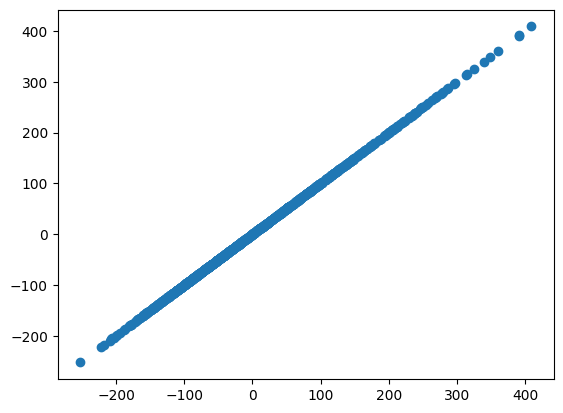

In [93]:
plt.scatter(delBioAgeTrainM, delBioAgeTrainM_R)

In [81]:
print("> Calculating BioAges for user data based on LinAge2 ... ", end="")
## BioAge deltas and BioAge for user data set
print("Females ... ", end="")
coxCovs_user_F = pd.DataFrame(coxCovs_user_F)
#delBioAge_user_F = calcBioAge(coxModelF, nullModelF, coxCovs_user_F)
delBioAge_user_F = calcBioAge_R_equiv(coxModelF, nullModelF, coxCovs_user_F,  coxCovsTrainF)
                    
bioAge_user_F = coxCovs_user_F["chronAge"].values + delBioAge_user_F

print("Males ... ", end="")
coxCovs_user_M = pd.DataFrame(coxCovs_user_M)
#delBioAge_user_M = calcBioAge(coxModelM, nullModelM, coxCovs_user_M)
delBioAge_user_M = calcBioAge_R_equiv(coxModelM, nullModelM, coxCovs_user_M,  coxCovsTrainM)
bioAge_user_M = coxCovs_user_M["chronAge"].values + delBioAge_user_M
print("Done")

> Calculating BioAges for user data based on LinAge2 ... Females ... Males ... Done


In [82]:
delBioAge_user_F_R = pd.read_csv("delBioAge_user_F_R.csv").values.squeeze()
bioAge_user_F_R    = pd.read_csv("bioAge_user_F_R.csv").values.squeeze()

delBioAge_user_M_R = pd.read_csv("delBioAge_user_M_R.csv").values.squeeze()
bioAge_user_M_R    = pd.read_csv("bioAge_user_M_R.csv").values.squeeze()

np.testing.assert_allclose(delBioAge_user_F, delBioAge_user_F_R, rtol=1e-3, atol=2e-5)
np.testing.assert_allclose(bioAge_user_F,    bioAge_user_F_R,    rtol=1e-3, atol=2e-5)
np.testing.assert_allclose(delBioAge_user_M, delBioAge_user_M_R, rtol=1e-3, atol=1e-1)
np.testing.assert_allclose(bioAge_user_M,    bioAge_user_M_R,    rtol=1e-3, atol=1e-1)

In [83]:
## Sort BA estimates back into the (mixed sex) testing data matrix (testing data)
print("> Sort BA into testing matrix ... for both sexes", end="")
nTest = demoTest.shape[0]
bioAge = np.zeros(nTest)
chrAge = demoTest["RIDAGEEX"].values

## Sort by SEQN
SEQnF = demoTest.loc[testUseF, "SEQN"].values
SEQnM = demoTest.loc[testUseM, "SEQN"].values
bioAge[np.isin(demoTest["SEQN"], SEQnF)] = bioAgeTestF
bioAge[np.isin(demoTest["SEQN"], SEQnM)] = bioAgeTestM
print("Done")

## Sort BA estimates back into the (mixed sex) testing data matrix (training data)
print("> Sort BA into training matrix ... for both sexes", end="")
nTrain = demoTrain.shape[0]
bioAge_train = np.zeros(nTrain)
chrAge_train = demoTrain["RIDAGEEX"].values

## Sort by SEQN
SEQnF_train = demoTrain.loc[trainUseF, "SEQN"].values
SEQnM_train = demoTrain.loc[trainUseM, "SEQN"].values
bioAge_train[np.isin(demoTrain["SEQN"], SEQnF_train)] = bioAgeTrainF
bioAge_train[np.isin(demoTrain["SEQN"], SEQnM_train)] = bioAgeTrainM
print("Done")

## Sort user data by SEQN
print("> Sort BA into user matrix ... for both sexes ... ", end="")
bioAge_user = np.zeros(userDataMat.shape[0])
SEQnF_user = qDataMat_user.loc[qDataMat_user["RIAGENDR"] == 2, "SEQN"].values
SEQnM_user = qDataMat_user.loc[qDataMat_user["RIAGENDR"] == 1, "SEQN"].values
print("Done")

print("> Adding PCs and LinAge2 data to user data matrix ... ", end="")
bioAge_user[np.isin(qDataMat_user["SEQN"], SEQnF_user)] = bioAge_user_F
bioAge_user[np.isin(qDataMat_user["SEQN"], SEQnM_user)] = bioAge_user_M
outMat = userDataOut()
print("Done")

## All done
print("#################################################################################")

## Have a quick look at the output data and investigate individual SEQ
userSEQs = outMat["SEQN"].values
print("> Data for SEQs:\n\n  ", end="")
print(userSEQs)
print("\n\n  added to the data matrix")

SEQnr = userSEQs[0]
while SEQnr != 0:
    SEQnr = input("\n> Enter SEQ Nr. to investigate single SEQ (enter zero to exit)\n> ")
    try:
        SEQnr = int(SEQnr)
        rowNr = np.where(userSEQs == SEQnr)[0]
        if SEQnr > 0 and len(rowNr) == 0:
            print(">>> No such SEQ! ")
        else:
            if SEQnr > 0:
                print(f"> SEQ: {SEQnr} has chronological age {outMat.iloc[rowNr[0]]['chronAge']} and LinAge2 {outMat.iloc[rowNr[0]]['linAge2']}")
                cols = plotBars(outMat, SEQnr)
                print("> Plotting PCs ... ", end="")
                plt.show()
                print("Done")
    except:
        break

## Write out the user data matrix with added bioAge and sex-specific PC data
print("> Writing updated user data matrix ... <userData_out.csv>")
outMat.to_csv("userData_out.csv", index=False)
print("Done")

print("<<< \n\n")

> Sort BA into testing matrix ... for both sexesDone
> Sort BA into training matrix ... for both sexesDone
> Sort BA into user matrix ... for both sexes ... Done
> Adding PCs and LinAge2 data to user data matrix ...  > Sanity check passed 
Done
#################################################################################
> Data for SEQs:

  [8881. 9106.]


  added to the data matrix



> Enter SEQ Nr. to investigate single SEQ (enter zero to exit)
>  8881


> SEQ: 8881 has chronological age 72.0 and LinAge2 88.7
> Writing updated user data matrix ... <userData_out.csv>
Done
<<< 




In [ ]:
svCut = 42
pcDatMat = pcDatMat.iloc[:, :svCut]
xTestPCA = pcDatMat[testSam].values
coxCovsTest = np.column_stack([initAgeTest, xTestPCA, sexTest])
coxCovsTest = pd.DataFrame(coxCovsTest, columns=['chronAge'] + list(pcDatMat.columns) + ['sex'])
coxCovsTestF = coxCovsTest[testUseF].reset_index(drop=True)
delBioAgeTestF  = calcBioAge_R_equiv(coxModelF, nullModelF, coxCovsTestF, coxCovsTrainF)
bioAgeTestF  = coxCovsTestF["chronAge"].to_numpy()  + delBioAgeTestF

In [ ]:
#### Visualization/interpretation things

In [ ]:
pc_indices = [int(x[2:])-1 for x in coxModelF.feature_names_in_ if 'PC' in x]

beta_full = np.zeros(59)
beta_full[pc_indices] = coxModelF.coef_[1:]
beta_age_null = nullModelF.coef_[0]

beta_age_full = coxModelF.coef_[0]

w_feature_years = (vMatDat99_F @ beta_full)/beta_age_null

w_age = (beta_age_full / beta_age_null) - 1.0



mu_PC = np.zeros(59)
mu_PC[pc_indices] = coxCovsTrainF.mean().loc[coxModelF.feature_names_in_].iloc[1:].values
mu_age = coxCovsTrainF['chronAge'].mean()

mu_Z = mu_PC@vMatDat99_F.T

Z_centered = inputMat01_F - mu_Z      # shape (n_samples, n_features)
term_features = (Z_centered @ w_feature_years)
term_age = (initAgeTest[testUseF] - mu_age) * w_age

alt_delta = term_features + term_age

In [ ]:
w_fea

In [ ]:
term_features

In [ ]:
plt.imshow((Z_centered * w_feature_years)[240:290], cmap='gray')

In [ ]:
userDataFile = "userData.csv"
userDataMat = pd.read_csv(userDataFile)


dataMat_user = dropCols(userDataMat, incList)  ## User data matrix for clock


qDataMat_user = qDataMatGen(userDataMat, incList)

dataMat_trans_user = boxCoxTransform(boxCox_lam, dataMat_user)

dataMatNorm_user = normAsZscores_99_young_mf(dataMat_trans_user, qDataMat_user, dataMat_trans, qDataMat)

zScoreMax = 6

dataMatUser_folded = foldOutliers(dataMatNorm_user, zScoreMax)

inputMat_user = dataMatUser_folded.iloc[:, 1:nCols].values

inputMat_user_M = inputMat_user[sexSel_user == 1, :]
inputMat_user_F = inputMat_user[sexSel_user == 2, :]


pcMat_user_M = projectToSVD(inputMat_user_M, vMatDat99_M)
pcMat_user_F = projectToSVD(inputMat_user_F, vMatDat99_F)


rowsAll_user = pcMat_user_M.shape[0] + pcMat_user_F.shape[0]
pcMat_user = np.zeros((rowsAll_user, colsAll))


pcMat_user[sexSel_user == 1, :] = pcMat_user_M
pcMat_user[sexSel_user == 2, :] = pcMat_user_F
pcMat_user = pd.DataFrame(pcMat_user, columns=[f"PC{i+1}" for i in range(nSVs99_M)])

coxCovs_user = np.column_stack([initAge_user, pcMat_user.values, sex_user])
coxCovs_user = pd.DataFrame(coxCovs_user, columns=['chronAge'] + list(pcMat_user.columns) + ['sex_user'])

## Split back into male / female to apply separate models
coxCovs_user_M = coxCovs_user[sex_user == 1]
coxCovs_user_F = coxCovs_user[sex_user == 2]

coxCovs_user_F = pd.DataFrame(coxCovs_user_F)

delBioAge_user_F = calcBioAge_R_equiv(coxModelF, nullModelF, coxCovs_user_F,  coxCovsTrainF)                    
bioAge_user_F = coxCovs_user_F["chronAge"].values + delBioAge_user_F

In [94]:
import joblib

joblib.dump(coxModelF, "artifacts/cox_full_F.joblib")
joblib.dump(nullModelF, "artifacts/cox_null_F.joblib")

joblib.dump(coxModelM, "artifacts/cox_full_M.joblib")
joblib.dump(nullModelM, "artifacts/cox_null_M.joblib")

['artifacts/cox_null_M.joblib']

In [96]:
coxCovsTrainF.to_csv("artifacts/coxCovsTrainF.csv")
coxCovsTrainM.to_csv("artifacts/coxCovsTrainM.csv")

In [98]:
bioAge_user_M

array([1064.41124048,  772.37231418,  862.93613224,  558.88493574,
        601.41319049, 1100.79292064, 1018.11091388,  923.31842593,
        567.3849557 ])

In [100]:
pd.read_csv('artifacts/dataMat_trans.csv').shape

(4423, 61)

In [ ]:
imputation_pool = masterData[nonAccidDeathFlags(masterData)].query('yearsNHANES == 9900')

In [140]:
sex = 2
age = 72*12



In [ ]:
imputation_bin = imputation_pool.query(f'RIAGENDR=={sex} & RIDAGEEX >={low} & RIDAGEEX <={high}')

In [ ]:
imputation_pool.sort_values(

In [143]:
count_reference_values(2, 33*12)

{'Unnamed: 0': 5101.5,
 'yearsNHANES': 9900.0,
 'SEQN': 5101.5,
 'RIAGENDR': 2.0,
 'RIDAGEYR': 32.0,
 'RIDAGEEX': 390.0,
 'BPQ020': 2.0,
 'DIQ010': 2.0,
 'HUQ010': 2.0,
 'HUQ020': 3.0,
 'HUQ050': 2.0,
 'HUQ070': 2.0,
 'KIQ020': 2.0,
 'MCQ010': 2.0,
 'MCQ053': 2.0,
 'MCQ160A': 2.0,
 'MCQ160B': 2.0,
 'MCQ160C': 2.0,
 'MCQ160D': 2.0,
 'MCQ160E': 2.0,
 'MCQ160F': 2.0,
 'MCQ160G': 2.0,
 'MCQ160I': 2.0,
 'MCQ160J': 2.0,
 'MCQ160K': 2.0,
 'MCQ160L': 2.0,
 'MCQ220': 2.0,
 'OSQ010A': 2.0,
 'OSQ010B': 2.0,
 'OSQ010C': 2.0,
 'OSQ060': 2.0,
 'PFQ056': 2.0,
 'BPXPLS': 76.0,
 'BPXSAR': 109.0,
 'BPXDAR': 67.0,
 'BMXBMI': 27.125,
 'URXUMASI': 6.8,
 'URXUCRSI': 10696.0,
 'LBDIRNSI': 14.32,
 'LBDTIBSI': 68.38,
 'LBXPCT': 20.8,
 'LBDFERSI': 30.0,
 'LBDFOLSI': 30.8,
 'LBDB12SI': 336.53,
 'LBXCOT': 0.0,
 'LBDTCSI': 4.89,
 'LBDHDLSI': 1.3849999999999998,
 'LBXWBCSI': 7.5,
 'LBXLYPCT': 27.6,
 'LBXMOPCT': 6.8,
 'LBXNEPCT': 62.1,
 'LBXEOPCT': 1.7,
 'LBXBAPCT': 0.6,
 'LBDLYMNO': 2.1,
 'LBDMONO': 0.5,
 'LBDNENO'

In [144]:
count_reference_values(2, -1*12)

{'Unnamed: 0': 4731.0,
 'yearsNHANES': 9900.0,
 'SEQN': 4731.0,
 'RIAGENDR': 2.0,
 'RIDAGEYR': 1.0,
 'RIDAGEEX': 18.0,
 'BPQ020': nan,
 'DIQ010': 2.0,
 'HUQ010': 1.0,
 'HUQ020': 3.0,
 'HUQ050': 3.0,
 'HUQ070': 2.0,
 'KIQ020': nan,
 'MCQ010': 2.0,
 'MCQ053': 2.0,
 'MCQ160A': nan,
 'MCQ160B': nan,
 'MCQ160C': nan,
 'MCQ160D': nan,
 'MCQ160E': nan,
 'MCQ160F': nan,
 'MCQ160G': nan,
 'MCQ160I': nan,
 'MCQ160J': nan,
 'MCQ160K': nan,
 'MCQ160L': nan,
 'MCQ220': nan,
 'OSQ010A': nan,
 'OSQ010B': nan,
 'OSQ010C': nan,
 'OSQ060': nan,
 'PFQ056': nan,
 'BPXPLS': nan,
 'BPXSAR': nan,
 'BPXDAR': nan,
 'BMXBMI': 15.87,
 'URXUMASI': nan,
 'URXUCRSI': nan,
 'LBDIRNSI': 12.26,
 'LBDTIBSI': 66.77,
 'LBXPCT': 17.9,
 'LBDFERSI': 23.0,
 'LBDFOLSI': 43.0,
 'LBDB12SI': 610.33,
 'LBXCOT': 0.0,
 'LBDTCSI': 4.3149999999999995,
 'LBDHDLSI': 1.31,
 'LBXWBCSI': 8.1,
 'LBXLYPCT': 52.1,
 'LBXMOPCT': 7.9,
 'LBXNEPCT': 36.650000000000006,
 'LBXEOPCT': 2.3,
 'LBXBAPCT': 0.6,
 'LBDLYMNO': 4.0,
 'LBDMONO': 0.6,
 'LBDNE

In [147]:
imputation_bin.iloc[0].to_dict()

{'Unnamed: 0': 40.0,
 'yearsNHANES': 9900.0,
 'SEQN': 40.0,
 'RIAGENDR': 2.0,
 'RIDAGEYR': 68.0,
 'RIDAGEEX': 829.0,
 'BPQ020': 1.0,
 'DIQ010': 1.0,
 'HUQ010': 5.0,
 'HUQ020': 3.0,
 'HUQ050': 3.0,
 'HUQ070': 2.0,
 'KIQ020': 2.0,
 'MCQ010': 2.0,
 'MCQ053': 2.0,
 'MCQ160A': 1.0,
 'MCQ160B': 2.0,
 'MCQ160C': 2.0,
 'MCQ160D': 2.0,
 'MCQ160E': 2.0,
 'MCQ160F': 2.0,
 'MCQ160G': 2.0,
 'MCQ160I': 2.0,
 'MCQ160J': 2.0,
 'MCQ160K': 2.0,
 'MCQ160L': 2.0,
 'MCQ220': 2.0,
 'OSQ010A': 2.0,
 'OSQ010B': 2.0,
 'OSQ010C': 2.0,
 'OSQ060': 2.0,
 'PFQ056': 2.0,
 'BPXPLS': 82.0,
 'BPXSAR': 167.0,
 'BPXDAR': 76.0,
 'BMXBMI': 30.23,
 'URXUMASI': 143.0,
 'URXUCRSI': 442.0,
 'LBDIRNSI': 7.52,
 'LBDTIBSI': 54.42,
 'LBXPCT': 13.8,
 'LBDFERSI': 136.0,
 'LBDFOLSI': 41.7,
 'LBDB12SI': 611.06,
 'LBXCOT': 0.0,
 'LBDTCSI': 6.54,
 'LBDHDLSI': 1.39,
 'LBXWBCSI': 10.4,
 'LBXLYPCT': 33.4,
 'LBXMOPCT': 5.0,
 'LBXNEPCT': 58.6,
 'LBXEOPCT': 2.5,
 'LBXBAPCT': 0.5,
 'LBDLYMNO': 3.5,
 'LBDMONO': 0.5,
 'LBDNENO': 6.1,
 'LBDEONO':